In [1]:
import torch
print('GPU Availability : ',torch.cuda.is_available())

GPU Availability :  True


In [2]:
import numpy as np
import torch
from torchvision import datasets
from torch.utils.data import Dataset
from PIL import Image

def get_dataset(name):
    if name == 'MNIST':
        return get_MNIST()
    elif name == 'FashionMNIST':
        return get_FashionMNIST()
    elif name == 'SVHN':
        return get_SVHN()
    elif name == 'CIFAR10':
        return get_CIFAR10()

def get_MNIST():
    raw_tr = datasets.MNIST('./MNIST', train=True, download=True)
    raw_te = datasets.MNIST('./MNIST', train=False, download=True)
    X_tr = raw_tr.train_data
    Y_tr = raw_tr.train_labels
    X_te = raw_te.test_data
    Y_te = raw_te.test_labels
    return X_tr, Y_tr, X_te, Y_te

def get_FashionMNIST():
    raw_tr = datasets.FashionMNIST('./FashionMNIST', train=True, download=True)
    raw_te = datasets.FashionMNIST('./FashionMNIST', train=False, download=True)
    X_tr = raw_tr.train_data
    Y_tr = raw_tr.train_labels
    X_te = raw_te.test_data
    Y_te = raw_te.test_labels
    return X_tr, Y_tr, X_te, Y_te

def get_SVHN():
    data_tr = datasets.SVHN('./SVHN', split='train', download=True)
    data_te = datasets.SVHN('./SVHN', split='test', download=True)
    X_tr = data_tr.data
    Y_tr = torch.from_numpy(data_tr.labels)
    X_te = data_te.data
    Y_te = torch.from_numpy(data_te.labels)
    return X_tr, Y_tr, X_te, Y_te

def get_CIFAR10():
    data_tr = datasets.CIFAR10('CIFAR10', train=True, download=True)
    data_te = datasets.CIFAR10('CIFAR10', train=False, download=True)
    X_tr = data_tr.data
    Y_tr = torch.from_numpy(np.array(data_tr.targets))
    X_te = data_te.data
    Y_te = torch.from_numpy(np.array(data_te.targets))
    return X_tr, Y_tr, X_te, Y_te

def get_handler(name):
    if name == 'MNIST':
        return DataHandler1
    elif name == 'FashionMNIST':
        return DataHandler1
    elif name == 'SVHN':
        return DataHandler2
    elif name == 'CIFAR10':
        return DataHandler3

class DataHandler1(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.X[index], self.Y[index]
        if self.transform is not None:
            x = Image.fromarray(x.numpy(), mode='L')
            x = self.transform(x)
        return x, y, index

    def __len__(self):
        return len(self.X)

class DataHandler2(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.X[index], self.Y[index]
        if self.transform is not None:
            x = Image.fromarray(np.transpose(x, (1, 2, 0)))
            x = self.transform(x)
        return x, y, index

    def __len__(self):
        return len(self.X)

class DataHandler3(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.X[index], self.Y[index]
        if self.transform is not None:
            x = Image.fromarray(x)
            x = self.transform(x)
        return x, y, index

    def __len__(self):
        return len(self.X)

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

def get_net(dataset_name, model_name=None, pretrained=True):
    if dataset_name == 'MNIST':
        return Net1
    elif dataset_name == 'FashionMNIST':
        return Net1
    elif dataset_name == 'SVHN':
        return Net2
    elif dataset_name == 'CIFAR10':
        if model_name == 'Inception3':
            inception = models.inception_v3(pretrained=pretrained)
            if pretrained:
                for param in list(inception.parameters())[:-1]:
                    param.requires_grad = False
            num_ftrs = inception.fc.in_features
            inception.fc = nn.Linear(num_ftrs, 10)
            return inception
        elif model_name == 'Squeezenet':
            squeezenet = models.squeezenet1_0(pretrained=pretrained)
            if pretrained:
                for param in list(squeezenet.parameters())[:-1]:
                    param.requires_grad = False
            squeezenet.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1,1), stride=(1,1))
            squeezenet.num_classes = 10
            return squeezenet
        elif model_name == 'Densenet':
            densenet = models.densenet161(pretrained=pretrained)   
            if pretrained:
                for param in list(densenet.parameters())[:-1]:
                    param.requires_grad = False
            num_ftrs = densenet.classifier.in_features
            densenet.classifier = nn.Linear(num_ftrs, 10)
            return densenet
        else:
            return Net3
            
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        e1 = F.relu(self.fc1(x))
        x = F.dropout(e1, training=self.training)
        x = self.fc2(x)
        return x, e1

    def get_embedding_dim(self):
        return 50

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1152, 400)
        self.fc2 = nn.Linear(400, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = x.view(-1, 1152)
        x = F.relu(self.fc1(x))
        e1 = F.relu(self.fc2(x))
        x = F.dropout(e1, training=self.training)
        x = self.fc3(x)
        return x, e1

    def get_embedding_dim(self):
        return 50

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 1024)
        e1 = F.relu(self.fc1(x))
        x = F.dropout(e1, training=self.training)
        x = self.fc2(x)
        return x, e1

    def get_embedding_dim(self):
        return 50

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import sys
import matplotlib.pyplot as plt
import time
from torchvision.models.inception import Inception3
from torchvision.models.squeezenet import SqueezeNet
from torchvision.models.densenet import DenseNet

def erase_line():
    CURSOR_UP_ONE = '\x1b[1A'
    ERASE_LINE = '\x1b[2K'
    sys.stdout.write(CURSOR_UP_ONE)
    sys.stdout.write(ERASE_LINE)

def accuracy_quick( predictions, target):
    # calling code must set mode = 'train' or 'eval'
    Y = torch.LongTensor(target.to('cpu'))
    oupt = predictions.to('cpu')
    (max_vals, arg_maxs) = torch.max(oupt.data, dim=1) 
    # arg_maxs is tensor of indices [0, 1, 0, 2, 1, 1 . . ]
    num_correct = torch.sum(Y==arg_maxs)
    acc = (1.0* num_correct * 100.0 / len(Y))
    return acc.item()  # percentage based

class Strategy:
    def __init__(self, X, Y, idxs_lb, net, handler, args):
        self.X = X
        self.Y = Y
        
        self.idxs_lb = idxs_lb
        self.net = net
        self.handler = handler
        self.args = args
        self.n_pool = len(Y)
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.train_losses = []
        self.val_losses = []
        self.train_acc = []
        self.val_acc = []
        self.valX = None
        self.valY = None
    def query(self, n):
        pass
    def set_test_data(self, x, y):
        self.valX = x 
        self.valY = y
        print("Test data set")

    def update(self, idxs_lb):
        self.idxs_lb = idxs_lb
        
    def plot_graphs(self, pause = False):
        plt.clf();
        fig = plt.figure(figsize=(15,6));
        ax = fig.add_subplot(121)
        ax.plot(self.train_losses, 'b', label='Training Loss')
        ax.plot(self.val_losses, 'r', label='Validation Loss')
        ax.legend()
        plt.xticks(range(len(self.train_losses)), range(1, len(self.train_losses)+1))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        bx = fig.add_subplot(122)
        bx.plot(self.train_acc, 'g', label='Training Accuracy')
        bx.plot(self.val_acc, 'm', label='Validation Accuracy')
        plt.xticks(range(len(self.train_acc)), range(1, len(self.train_acc)+1))
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy %')
        plt.ylim([0,100])
        bx.legend()
        if pause:
            plt.show()
        else:
            plt.pause(1e-10)

    def save_graph(self):
        plt.clf();
        fig = plt.figure(figsize=(6,6));
        ax = fig.add_subplot(111)
        ax.plot(self.train_losses, 'b', label='Training Loss')
        ax.plot(self.val_losses, 'r', label='Validation Loss')
        plt.xticks(range(len(self.train_losses)), range(1, len(self.train_losses)+1))
        ax.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        time_ = time.strftime('%Y-%m-%dT%H:%M:%S', time.localtime())
        #plt.savefig( time_+"_Losses.png")
        plt.clf();
        fig = plt.figure(figsize=(6,6));
        bx = fig.add_subplot(111)
        bx.plot(self.train_acc, 'g', label='Training Accuracy')
        bx.plot(self.val_acc, 'm', label='Validation Accuracy')
        plt.xticks(range(len(self.train_acc)), range(1, len(self.train_acc)+1))
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy %')
        plt.ylim([0,100])
        bx.legend()
        #plt.savefig( time_ + "_Accuracy.png")

        print("Graphs have been saved to: " + time_ + " files")
        

    def _train(self, epoch, loader_tr, optimizer):
        self.clf.train()
        total_number = len(loader_tr)
        update_rate = 5
    
        # Initiate accuracies and losses per epoch
        final_train_accuracy = 0
        final_train_loss = 0
        final_val_loss = 0
        final_val_acc = 0

        for batch_idx, (x, y, idxs) in enumerate(loader_tr):
            x, y = x.to(self.device), y.to(self.device)
            optimizer.zero_grad()
            #print(len(self.clf(x)))
            if isinstance(self.clf, (SqueezeNet,DenseNet)):
                    out = self.clf(x)
            else:
                out, e1 = self.clf(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()
            if batch_idx%update_rate==0:
                if(batch_idx>0):
                    erase_line()
                progress = batch_idx/total_number*100
                acc = accuracy_quick(out.to(self.device), y.to(self.device))
                final_train_accuracy = acc
                final_train_loss = loss
                print('Training\t Progress:\t %f %%\tLoss: %f\t Training Accuracy %0.2f %%' %(progress, loss, acc))
             
        """
        Validation

        Load the test data and compute loss and accuracy
        """

        loader_te = DataLoader(self.handler(self.valX, self.valY, transform=self.args['transform']),
                            shuffle=False, **self.args['loader_te_args'])

        self.clf.eval()
        loss = 0
        n = 0
        predictions = torch.zeros(len(self.valY), dtype=self.valY.dtype)
        with torch.no_grad():
            for x, y, idxs in loader_te:
                x, y = x.to(self.device), y.to(self.device)
                #print(len(self.clf(x)))
                if isinstance(self.clf, (Inception3,SqueezeNet,DenseNet)):
                    out = self.clf(x)
                else:
                    out, e1 = self.clf(x)
                loss +=  F.cross_entropy(out, y)
                n+=1
                pred = out.max(1)[1]
                predictions[idxs] = pred.cpu()

          
        final_val_acc = 100.0* (self.valY==predictions).sum().item() / len(self.valY)
        final_val_loss =  1.0*loss/n
        print('\nValidation\n=========\nProgress:\t 100 %%\nValidation Loss: %f\nValidation Accuracy %0.2f %%\n' %( final_val_loss, final_val_acc))
        return final_train_loss, final_val_loss, final_train_accuracy, final_val_acc
                
            

                
    def train(self):

        n_epoch = self.args['n_epoch']
        self.clf = self.net.to(self.device) if isinstance(self.net,(Inception3,DenseNet,SqueezeNet)) else self.net().to(self.device)
        optimizer = optim.SGD(self.clf.parameters(), **self.args['optimizer_args'])

        idxs_train = np.arange(self.n_pool)[self.idxs_lb]
        loader_tr = DataLoader(self.handler(self.X[idxs_train], self.Y[idxs_train], transform=self.args['transform']),
                            shuffle=True, **self.args['loader_tr_args'])
        
        for epoch in range(1, n_epoch+1):
            print("="*100 + '\n')
            print('Epoch %d of %d' %(epoch, n_epoch))
            train_loss, val_loss, train_acc, val_acc = self._train(epoch, loader_tr, optimizer)
            
            # plot
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_acc.append(train_acc)
            self.val_acc.append(val_acc)
            self.plot_graphs()


    def predict(self, X, Y):
        loader_te = DataLoader(self.handler(X, Y, transform=self.args['transform']),
                            shuffle=False, **self.args['loader_te_args'])

        self.clf.eval()
        P = torch.zeros(len(Y), dtype=Y.dtype)
        with torch.no_grad():
            for x, y, idxs in loader_te:
                x, y = x.to(self.device), y.to(self.device)
                if isinstance(self.clf, (Inception3,SqueezeNet,DenseNet)):
                    out = self.clf(x)
                else:
                    out, e1 = self.clf(x)
                pred = out.max(1)[1]
                P[idxs] = pred.cpu()

        return P

    

    def predict_prob(self, X, Y):
        loader_te = DataLoader(self.handler(X, Y, transform=self.args['transform']),
                            shuffle=False, **self.args['loader_te_args'])

        self.clf.eval()
        probs = torch.zeros([len(Y), len(np.unique(Y))])
        with torch.no_grad():
            for x, y, idxs in loader_te:
                x, y = x.to(self.device), y.to(self.device)
                out, e1 = self.clf(x)
                prob = F.softmax(out, dim=1)
                probs[idxs] = prob.cpu()
        
        return probs

    def predict_prob_dropout(self, X, Y, n_drop):
        loader_te = DataLoader(self.handler(X, Y, transform=self.args['transform']),
                            shuffle=False, **self.args['loader_te_args'])

        self.clf.train()
        probs = torch.zeros([len(Y), len(np.unique(Y))])
        for i in range(n_drop):
            print('n_drop {}/{}'.format(i+1, n_drop))
            with torch.no_grad():
                for x, y, idxs in loader_te:
                    x, y = x.to(self.device), y.to(self.device)
                    out, e1 = self.clf(x)
                    prob = F.softmax(out, dim=1)
                    probs[idxs] += prob.cpu()
        probs /= n_drop
        
        return probs

    def predict_prob_dropout_split(self, X, Y, n_drop):
        loader_te = DataLoader(self.handler(X, Y, transform=self.args['transform']),
                            shuffle=False, **self.args['loader_te_args'])

        self.clf.train()
        probs = torch.zeros([n_drop, len(Y), len(np.unique(Y))])
        for i in range(n_drop):
            print('n_drop {}/{}'.format(i+1, n_drop))
            with torch.no_grad():
                for x, y, idxs in loader_te:
                    x, y = x.to(self.device), y.to(self.device)
                    out, e1 = self.clf(x)
                    probs[i][idxs] += F.softmax(out, dim=1).cpu()
        
        return probs

    def get_embedding(self, X, Y):
        loader_te = DataLoader(self.handler(X, Y, transform=self.args['transform']),
                            shuffle=False, **self.args['loader_te_args'])

        self.clf.eval()
        embedding = torch.zeros([len(Y), self.clf.get_embedding_dim()])
        with torch.no_grad():
            for x, y, idxs in loader_te:
                x, y = x.to(self.device), y.to(self.device)
                out, e1 = self.clf(x)
                embedding[idxs] = e1.cpu()
        
        return embedding



## Random Sampling
import numpy as np
#from .strategy import Strategy

class RandomSampling(Strategy):
    def __init__(self, X, Y, idxs_lb, net, handler, args):
        super(RandomSampling, self).__init__(X, Y, idxs_lb, net, handler, args)

    def query(self, n):
        return np.random.choice(np.where(self.idxs_lb==0)[0], n)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Running...
=========== Training Model : Inception3, Pretrained : True =====================


170500096it [00:01, 86501621.72it/s]                               


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified
number of labeled pool: 10000
number of unlabeled pool: 30000
number of testing pool: 10000


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /tmp/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:01<00:00, 95.4MB/s]


<class 'torchvision.models.inception.Inception3'>
CIFAR10
SEED 1
RandomSampling
Test data set

Epoch 1 of 5
Training	 Progress:	 0.000000 %	Loss: 2.300101	 Training Accuracy 9.00 %
Training	 Progress:	 1.597444 %	Loss: 2.336154	 Training Accuracy 15.00 %
Training	 Progress:	 3.194888 %	Loss: 1.924155	 Training Accuracy 40.00 %
Training	 Progress:	 4.792332 %	Loss: 2.140963	 Training Accuracy 21.00 %
Training	 Progress:	 6.389776 %	Loss: 1.700529	 Training Accuracy 50.00 %
Training	 Progress:	 7.987220 %	Loss: 1.658445	 Training Accuracy 46.00 %
Training	 Progress:	 9.584665 %	Loss: 1.765574	 Training Accuracy 34.00 %
Training	 Progress:	 11.182109 %	Loss: 1.311258	 Training Accuracy 59.00 %
Training	 Progress:	 12.779553 %	Loss: 1.482142	 Training Accuracy 50.00 %
Training	 Progress:	 14.376997 %	Loss: 1.514783	 Training Accuracy 46.00 %
Training	 Progress:	 15.974441 %	Loss: 1.574283	 Training Accuracy 46.00 %
Training	 Progress:	 17.571885 %	Loss: 1.452168	 Training Accuracy 46.00 %


<Figure size 432x288 with 0 Axes>

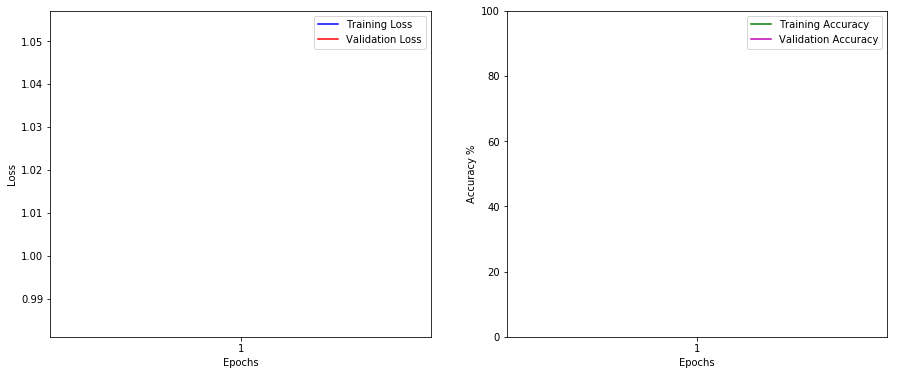


Epoch 2 of 5
Training	 Progress:	 0.000000 %	Loss: 1.299361	 Training Accuracy 56.00 %
Training	 Progress:	 1.597444 %	Loss: 1.147201	 Training Accuracy 62.00 %
Training	 Progress:	 3.194888 %	Loss: 1.300649	 Training Accuracy 65.00 %
Training	 Progress:	 4.792332 %	Loss: 1.289914	 Training Accuracy 53.00 %
Training	 Progress:	 6.389776 %	Loss: 0.821613	 Training Accuracy 71.00 %
Training	 Progress:	 7.987220 %	Loss: 1.706513	 Training Accuracy 50.00 %
Training	 Progress:	 9.584665 %	Loss: 1.295527	 Training Accuracy 62.00 %
Training	 Progress:	 11.182109 %	Loss: 0.797620	 Training Accuracy 81.00 %
Training	 Progress:	 12.779553 %	Loss: 1.025624	 Training Accuracy 56.00 %
Training	 Progress:	 14.376997 %	Loss: 0.991531	 Training Accuracy 68.00 %
Training	 Progress:	 15.974441 %	Loss: 0.880584	 Training Accuracy 68.00 %
Training	 Progress:	 17.571885 %	Loss: 1.072151	 Training Accuracy 62.00 %
Training	 Progress:	 19.169329 %	Loss: 1.252673	 Training Accuracy 53.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

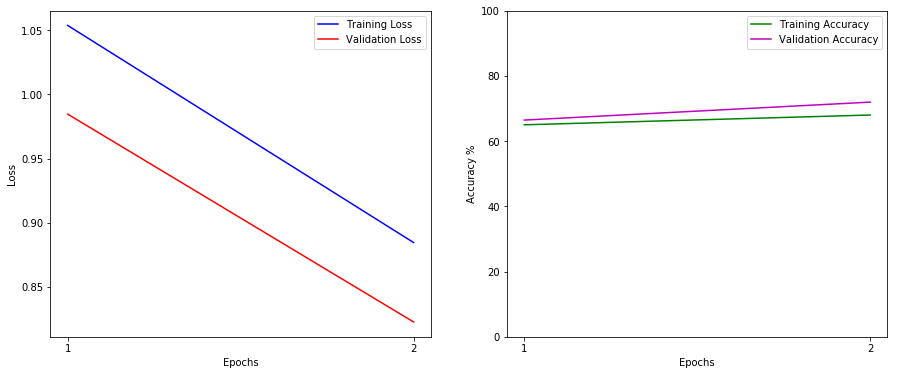


Epoch 3 of 5
Training	 Progress:	 0.000000 %	Loss: 0.768263	 Training Accuracy 65.00 %
Training	 Progress:	 1.597444 %	Loss: 0.821011	 Training Accuracy 75.00 %
Training	 Progress:	 3.194888 %	Loss: 0.705190	 Training Accuracy 75.00 %
Training	 Progress:	 4.792332 %	Loss: 0.990728	 Training Accuracy 65.00 %
Training	 Progress:	 6.389776 %	Loss: 1.109395	 Training Accuracy 59.00 %
Training	 Progress:	 7.987220 %	Loss: 0.902759	 Training Accuracy 65.00 %
Training	 Progress:	 9.584665 %	Loss: 0.878130	 Training Accuracy 68.00 %
Training	 Progress:	 11.182109 %	Loss: 0.665305	 Training Accuracy 65.00 %
Training	 Progress:	 12.779553 %	Loss: 0.714344	 Training Accuracy 71.00 %
Training	 Progress:	 14.376997 %	Loss: 0.945992	 Training Accuracy 75.00 %
Training	 Progress:	 15.974441 %	Loss: 0.789889	 Training Accuracy 75.00 %
Training	 Progress:	 17.571885 %	Loss: 0.984497	 Training Accuracy 65.00 %
Training	 Progress:	 19.169329 %	Loss: 1.014925	 Training Accuracy 68.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

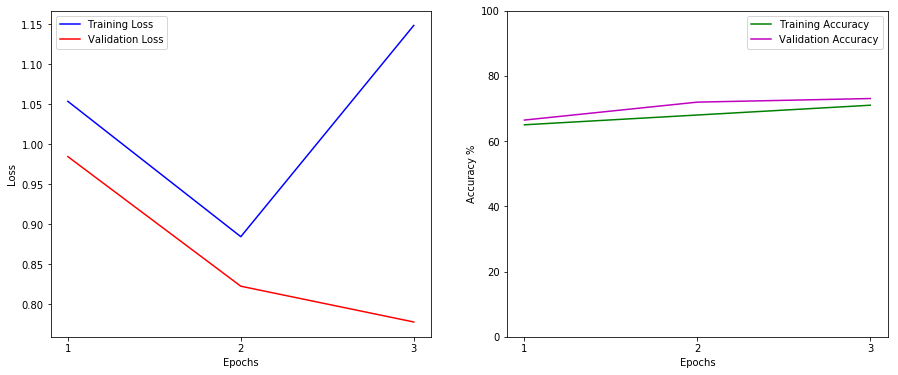


Epoch 4 of 5
Training	 Progress:	 0.000000 %	Loss: 0.942867	 Training Accuracy 62.00 %
Training	 Progress:	 1.597444 %	Loss: 1.264962	 Training Accuracy 68.00 %
Training	 Progress:	 3.194888 %	Loss: 0.884051	 Training Accuracy 65.00 %
Training	 Progress:	 4.792332 %	Loss: 0.701196	 Training Accuracy 81.00 %
Training	 Progress:	 6.389776 %	Loss: 1.292836	 Training Accuracy 50.00 %
Training	 Progress:	 7.987220 %	Loss: 1.182337	 Training Accuracy 59.00 %
Training	 Progress:	 9.584665 %	Loss: 0.766368	 Training Accuracy 68.00 %
Training	 Progress:	 11.182109 %	Loss: 1.714466	 Training Accuracy 59.00 %
Training	 Progress:	 12.779553 %	Loss: 0.988780	 Training Accuracy 59.00 %
Training	 Progress:	 14.376997 %	Loss: 0.611940	 Training Accuracy 81.00 %
Training	 Progress:	 15.974441 %	Loss: 1.200884	 Training Accuracy 68.00 %
Training	 Progress:	 17.571885 %	Loss: 0.695869	 Training Accuracy 78.00 %
Training	 Progress:	 19.169329 %	Loss: 0.669984	 Training Accuracy 78.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

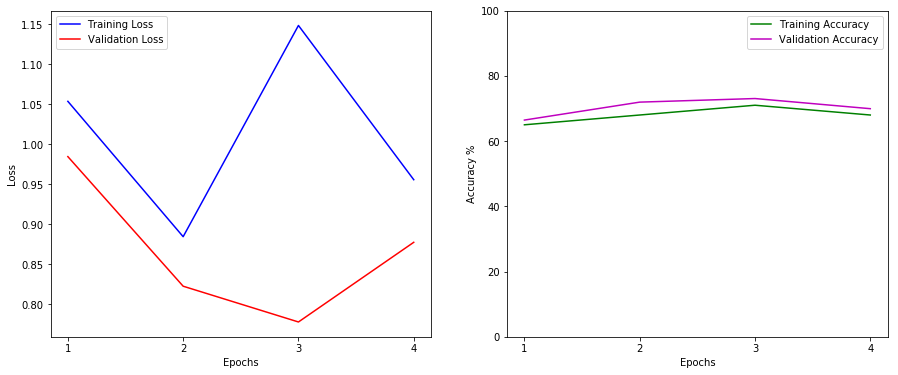


Epoch 5 of 5
Training	 Progress:	 0.000000 %	Loss: 0.701399	 Training Accuracy 75.00 %
Training	 Progress:	 1.597444 %	Loss: 0.775470	 Training Accuracy 68.00 %
Training	 Progress:	 3.194888 %	Loss: 1.046590	 Training Accuracy 62.00 %
Training	 Progress:	 4.792332 %	Loss: 1.046721	 Training Accuracy 68.00 %
Training	 Progress:	 6.389776 %	Loss: 1.191475	 Training Accuracy 62.00 %
Training	 Progress:	 7.987220 %	Loss: 1.131282	 Training Accuracy 56.00 %
Training	 Progress:	 9.584665 %	Loss: 1.257448	 Training Accuracy 53.00 %
Training	 Progress:	 11.182109 %	Loss: 1.081985	 Training Accuracy 68.00 %
Training	 Progress:	 12.779553 %	Loss: 0.686904	 Training Accuracy 81.00 %
Training	 Progress:	 14.376997 %	Loss: 1.001204	 Training Accuracy 56.00 %
Training	 Progress:	 15.974441 %	Loss: 0.647676	 Training Accuracy 81.00 %
Training	 Progress:	 17.571885 %	Loss: 1.111669	 Training Accuracy 68.00 %
Training	 Progress:	 19.169329 %	Loss: 0.893357	 Training Accuracy 68.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

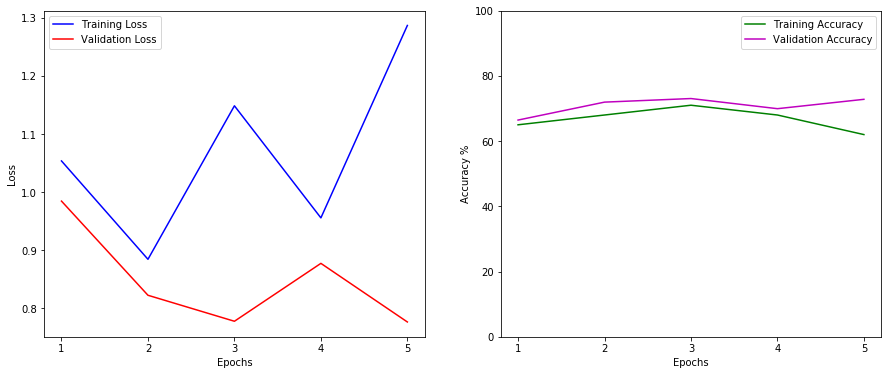

Round 0
testing accuracy 0.7281
Round 1

Epoch 1 of 5
Training	 Progress:	 0.000000 %	Loss: 1.156271	 Training Accuracy 71.00 %
Training	 Progress:	 1.453488 %	Loss: 0.565309	 Training Accuracy 71.00 %
Training	 Progress:	 2.906977 %	Loss: 1.101136	 Training Accuracy 62.00 %
Training	 Progress:	 4.360465 %	Loss: 1.072160	 Training Accuracy 62.00 %
Training	 Progress:	 5.813953 %	Loss: 1.312432	 Training Accuracy 50.00 %
Training	 Progress:	 7.267442 %	Loss: 1.247884	 Training Accuracy 62.00 %
Training	 Progress:	 8.720930 %	Loss: 0.824704	 Training Accuracy 75.00 %
Training	 Progress:	 10.174419 %	Loss: 1.025626	 Training Accuracy 71.00 %
Training	 Progress:	 11.627907 %	Loss: 1.141025	 Training Accuracy 65.00 %
Training	 Progress:	 13.081395 %	Loss: 1.310043	 Training Accuracy 59.00 %
Training	 Progress:	 14.534884 %	Loss: 0.928575	 Training Accuracy 71.00 %
Training	 Progress:	 15.988372 %	Loss: 1.023419	 Training Accuracy 65.00 %
Training	 Progress:	 17.441860 %	Loss: 0.823853	 Trai

<Figure size 432x288 with 0 Axes>

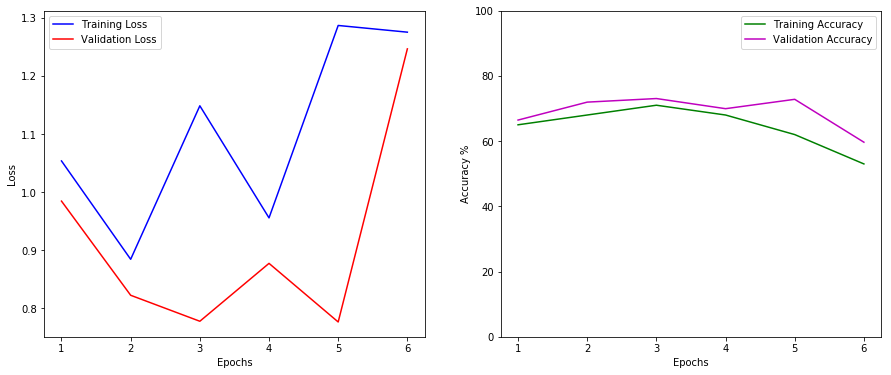


Epoch 2 of 5
Training	 Progress:	 0.000000 %	Loss: 1.240849	 Training Accuracy 62.00 %
Training	 Progress:	 1.453488 %	Loss: 0.885573	 Training Accuracy 68.00 %
Training	 Progress:	 2.906977 %	Loss: 1.022397	 Training Accuracy 62.00 %
Training	 Progress:	 4.360465 %	Loss: 1.092348	 Training Accuracy 75.00 %
Training	 Progress:	 5.813953 %	Loss: 1.047151	 Training Accuracy 68.00 %
Training	 Progress:	 7.267442 %	Loss: 1.036710	 Training Accuracy 62.00 %
Training	 Progress:	 8.720930 %	Loss: 0.848214	 Training Accuracy 68.00 %
Training	 Progress:	 10.174419 %	Loss: 0.632994	 Training Accuracy 78.00 %
Training	 Progress:	 11.627907 %	Loss: 1.028536	 Training Accuracy 68.00 %
Training	 Progress:	 13.081395 %	Loss: 0.679147	 Training Accuracy 84.00 %
Training	 Progress:	 14.534884 %	Loss: 0.866499	 Training Accuracy 65.00 %
Training	 Progress:	 15.988372 %	Loss: 0.824970	 Training Accuracy 75.00 %
Training	 Progress:	 17.441860 %	Loss: 1.151411	 Training Accuracy 65.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

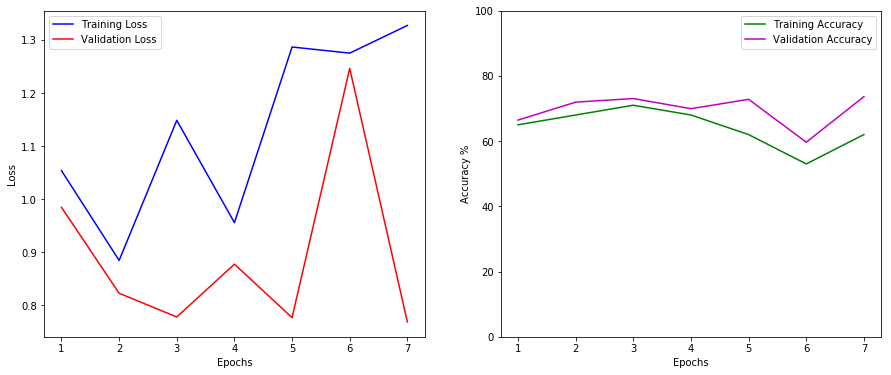


Epoch 3 of 5
Training	 Progress:	 0.000000 %	Loss: 0.579216	 Training Accuracy 75.00 %
Training	 Progress:	 1.453488 %	Loss: 0.878045	 Training Accuracy 71.00 %
Training	 Progress:	 2.906977 %	Loss: 1.343383	 Training Accuracy 62.00 %
Training	 Progress:	 4.360465 %	Loss: 1.488562	 Training Accuracy 53.00 %
Training	 Progress:	 5.813953 %	Loss: 0.648692	 Training Accuracy 78.00 %
Training	 Progress:	 7.267442 %	Loss: 0.826210	 Training Accuracy 71.00 %
Training	 Progress:	 8.720930 %	Loss: 0.875102	 Training Accuracy 59.00 %
Training	 Progress:	 10.174419 %	Loss: 0.834827	 Training Accuracy 65.00 %
Training	 Progress:	 11.627907 %	Loss: 0.516334	 Training Accuracy 81.00 %
Training	 Progress:	 13.081395 %	Loss: 0.772215	 Training Accuracy 68.00 %
Training	 Progress:	 14.534884 %	Loss: 1.218773	 Training Accuracy 56.00 %
Training	 Progress:	 15.988372 %	Loss: 1.065582	 Training Accuracy 71.00 %
Training	 Progress:	 17.441860 %	Loss: 0.761000	 Training Accuracy 78.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

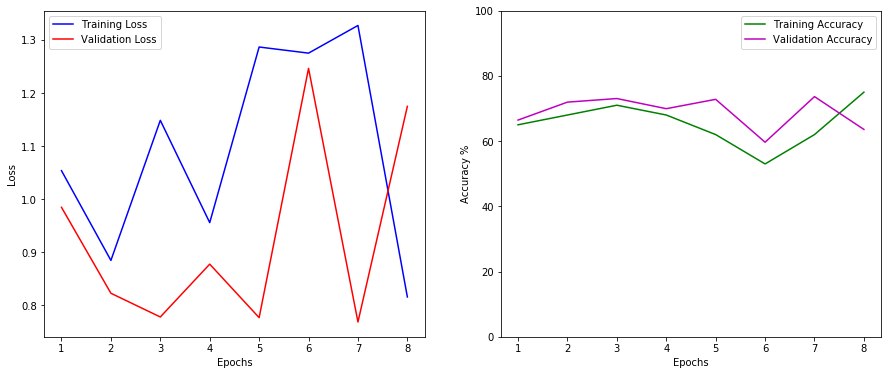


Epoch 4 of 5
Training	 Progress:	 0.000000 %	Loss: 1.436805	 Training Accuracy 50.00 %
Training	 Progress:	 1.453488 %	Loss: 0.840480	 Training Accuracy 65.00 %
Training	 Progress:	 2.906977 %	Loss: 0.879102	 Training Accuracy 71.00 %
Training	 Progress:	 4.360465 %	Loss: 0.998114	 Training Accuracy 59.00 %
Training	 Progress:	 5.813953 %	Loss: 0.888561	 Training Accuracy 68.00 %
Training	 Progress:	 7.267442 %	Loss: 1.127673	 Training Accuracy 65.00 %
Training	 Progress:	 8.720930 %	Loss: 0.796093	 Training Accuracy 68.00 %
Training	 Progress:	 10.174419 %	Loss: 0.828207	 Training Accuracy 71.00 %
Training	 Progress:	 11.627907 %	Loss: 1.462533	 Training Accuracy 62.00 %
Training	 Progress:	 13.081395 %	Loss: 1.090353	 Training Accuracy 68.00 %
Training	 Progress:	 14.534884 %	Loss: 1.032656	 Training Accuracy 65.00 %
Training	 Progress:	 15.988372 %	Loss: 1.364031	 Training Accuracy 59.00 %
Training	 Progress:	 17.441860 %	Loss: 0.605817	 Training Accuracy 75.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

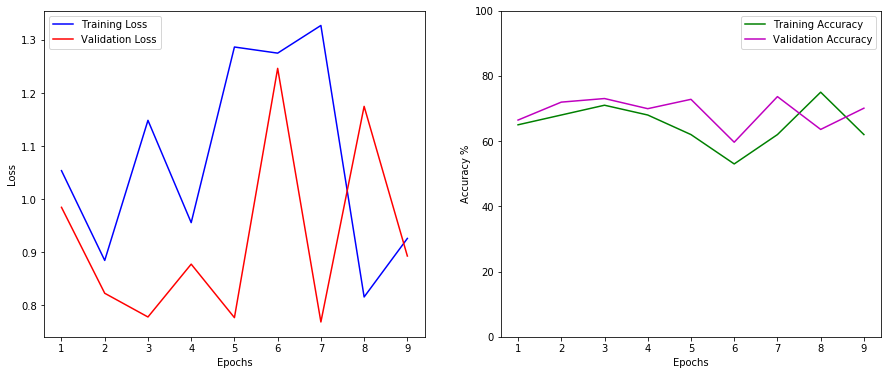


Epoch 5 of 5
Training	 Progress:	 0.000000 %	Loss: 1.066079	 Training Accuracy 59.00 %
Training	 Progress:	 1.453488 %	Loss: 0.988005	 Training Accuracy 62.00 %
Training	 Progress:	 2.906977 %	Loss: 0.762186	 Training Accuracy 78.00 %
Training	 Progress:	 4.360465 %	Loss: 1.098402	 Training Accuracy 56.00 %
Training	 Progress:	 5.813953 %	Loss: 0.695161	 Training Accuracy 81.00 %
Training	 Progress:	 7.267442 %	Loss: 1.123055	 Training Accuracy 65.00 %
Training	 Progress:	 8.720930 %	Loss: 0.704616	 Training Accuracy 84.00 %
Training	 Progress:	 10.174419 %	Loss: 1.533572	 Training Accuracy 56.00 %
Training	 Progress:	 11.627907 %	Loss: 1.050740	 Training Accuracy 62.00 %
Training	 Progress:	 13.081395 %	Loss: 0.960029	 Training Accuracy 65.00 %
Training	 Progress:	 14.534884 %	Loss: 1.041719	 Training Accuracy 65.00 %
Training	 Progress:	 15.988372 %	Loss: 1.216904	 Training Accuracy 62.00 %
Training	 Progress:	 17.441860 %	Loss: 0.966266	 Training Accuracy 65.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

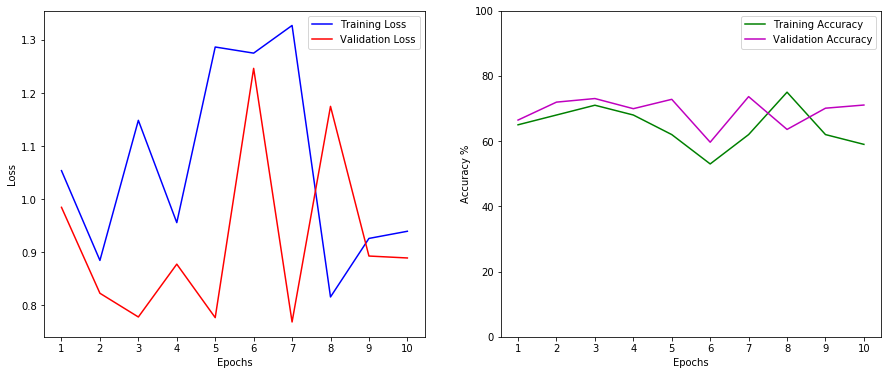

testing accuracy 0.7106
Graphs have been saved to: 2019-09-30T10:49:50 files


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

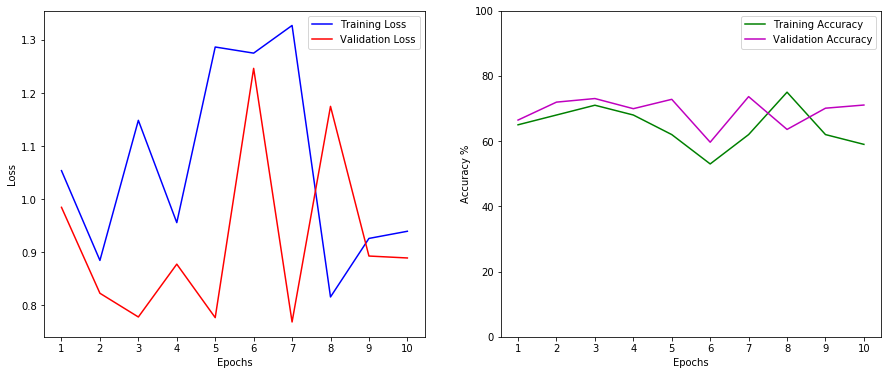

[tensor(1.0536, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.8846, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1484, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.9557, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.2865, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.2750, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.3271, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.8157, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.9260, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.9395, device='cuda:0', grad_fn=<NllLossBackward>)]
[tensor(0.9846, device='cuda:0'), tensor(0.8227, device='cuda:0'), tensor(0.7780, device='cuda:0'), tensor(0.8775, device='cuda:0'), tensor(0.7768, device='cuda:0'), tensor(1.2463, device='cuda:0'), tensor(0.7686, device='cuda:0'), tensor(1.1747, device='cuda:0'), tensor(0.8928, device='cuda:0'), tensor(0.8892, device='cuda:0')]
[65, 68, 71, 68, 62, 53, 62, 75, 62, 59]
[66.45, 71.95, 73.05, 69.94

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 89.3MB/s]


<class 'torchvision.models.densenet.DenseNet'>
CIFAR10
SEED 1
RandomSampling
Test data set

Epoch 1 of 5
Training	 Progress:	 0.000000 %	Loss: 2.333779	 Training Accuracy 0.00 %
Training	 Progress:	 1.597444 %	Loss: 2.152241	 Training Accuracy 12.00 %
Training	 Progress:	 3.194888 %	Loss: 3.507308	 Training Accuracy 15.00 %
Training	 Progress:	 4.792332 %	Loss: 1.987088	 Training Accuracy 31.00 %
Training	 Progress:	 6.389776 %	Loss: 1.442915	 Training Accuracy 65.00 %
Training	 Progress:	 7.987220 %	Loss: 1.815346	 Training Accuracy 59.00 %
Training	 Progress:	 9.584665 %	Loss: 1.063984	 Training Accuracy 59.00 %
Training	 Progress:	 11.182109 %	Loss: 2.328513	 Training Accuracy 28.00 %
Training	 Progress:	 12.779553 %	Loss: 1.181806	 Training Accuracy 62.00 %
Training	 Progress:	 14.376997 %	Loss: 0.677346	 Training Accuracy 71.00 %
Training	 Progress:	 15.974441 %	Loss: 1.071739	 Training Accuracy 56.00 %
Training	 Progress:	 17.571885 %	Loss: 1.063487	 Training Accuracy 68.00 %
Tra

<Figure size 432x288 with 0 Axes>

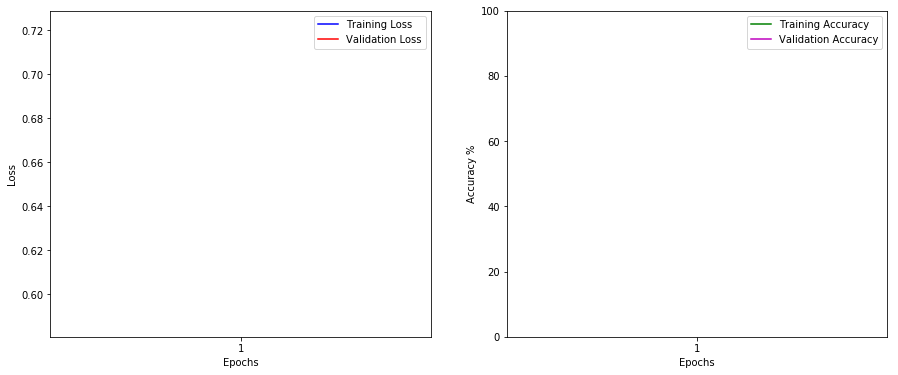


Epoch 2 of 5
Training	 Progress:	 0.000000 %	Loss: 0.521322	 Training Accuracy 81.00 %
Training	 Progress:	 1.597444 %	Loss: 0.650369	 Training Accuracy 81.00 %
Training	 Progress:	 3.194888 %	Loss: 0.469857	 Training Accuracy 84.00 %
Training	 Progress:	 4.792332 %	Loss: 0.528786	 Training Accuracy 84.00 %
Training	 Progress:	 6.389776 %	Loss: 0.853405	 Training Accuracy 75.00 %
Training	 Progress:	 7.987220 %	Loss: 0.437237	 Training Accuracy 84.00 %
Training	 Progress:	 9.584665 %	Loss: 0.507220	 Training Accuracy 75.00 %
Training	 Progress:	 11.182109 %	Loss: 0.235488	 Training Accuracy 90.00 %
Training	 Progress:	 12.779553 %	Loss: 0.287642	 Training Accuracy 90.00 %
Training	 Progress:	 14.376997 %	Loss: 0.595677	 Training Accuracy 78.00 %
Training	 Progress:	 15.974441 %	Loss: 0.924367	 Training Accuracy 75.00 %
Training	 Progress:	 17.571885 %	Loss: 0.295081	 Training Accuracy 93.00 %
Training	 Progress:	 19.169329 %	Loss: 0.664358	 Training Accuracy 81.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

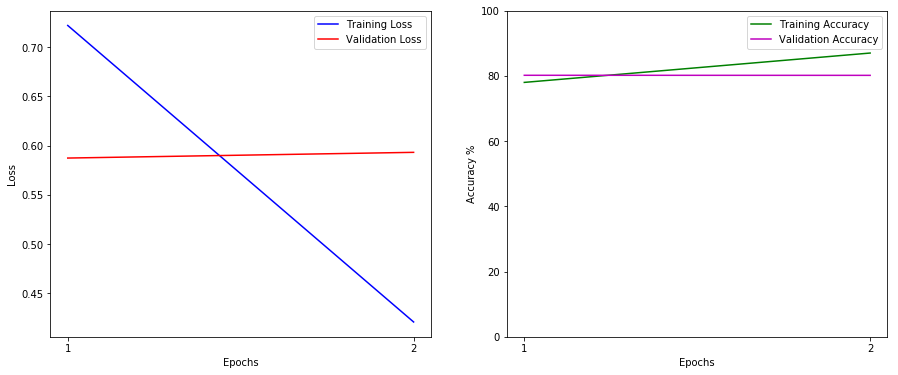


Epoch 3 of 5
Training	 Progress:	 0.000000 %	Loss: 0.375513	 Training Accuracy 90.00 %
Training	 Progress:	 1.597444 %	Loss: 0.511169	 Training Accuracy 81.00 %
Training	 Progress:	 3.194888 %	Loss: 0.392123	 Training Accuracy 81.00 %
Training	 Progress:	 4.792332 %	Loss: 0.587890	 Training Accuracy 81.00 %
Training	 Progress:	 6.389776 %	Loss: 0.267268	 Training Accuracy 90.00 %
Training	 Progress:	 7.987220 %	Loss: 0.200897	 Training Accuracy 93.00 %
Training	 Progress:	 9.584665 %	Loss: 0.273604	 Training Accuracy 90.00 %
Training	 Progress:	 11.182109 %	Loss: 0.447251	 Training Accuracy 84.00 %
Training	 Progress:	 12.779553 %	Loss: 0.631516	 Training Accuracy 71.00 %
Training	 Progress:	 14.376997 %	Loss: 0.338660	 Training Accuracy 84.00 %
Training	 Progress:	 15.974441 %	Loss: 0.870516	 Training Accuracy 78.00 %
Training	 Progress:	 17.571885 %	Loss: 0.436561	 Training Accuracy 78.00 %
Training	 Progress:	 19.169329 %	Loss: 0.814657	 Training Accuracy 71.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

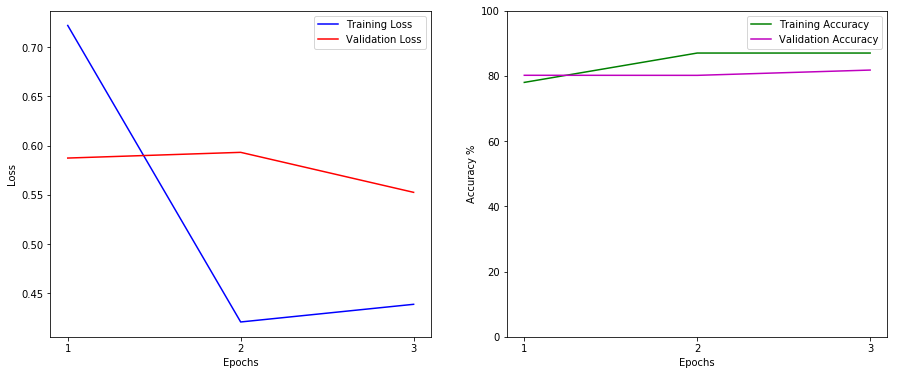


Epoch 4 of 5
Training	 Progress:	 0.000000 %	Loss: 0.536055	 Training Accuracy 78.00 %
Training	 Progress:	 1.597444 %	Loss: 0.462466	 Training Accuracy 87.00 %
Training	 Progress:	 3.194888 %	Loss: 0.339371	 Training Accuracy 81.00 %
Training	 Progress:	 4.792332 %	Loss: 0.614490	 Training Accuracy 81.00 %
Training	 Progress:	 6.389776 %	Loss: 0.386300	 Training Accuracy 84.00 %
Training	 Progress:	 7.987220 %	Loss: 0.212655	 Training Accuracy 93.00 %
Training	 Progress:	 9.584665 %	Loss: 0.577452	 Training Accuracy 84.00 %
Training	 Progress:	 11.182109 %	Loss: 0.313518	 Training Accuracy 87.00 %
Training	 Progress:	 12.779553 %	Loss: 0.499731	 Training Accuracy 78.00 %
Training	 Progress:	 14.376997 %	Loss: 0.512511	 Training Accuracy 78.00 %
Training	 Progress:	 15.974441 %	Loss: 0.564662	 Training Accuracy 81.00 %
Training	 Progress:	 17.571885 %	Loss: 0.124569	 Training Accuracy 96.00 %
Training	 Progress:	 19.169329 %	Loss: 0.271518	 Training Accuracy 87.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

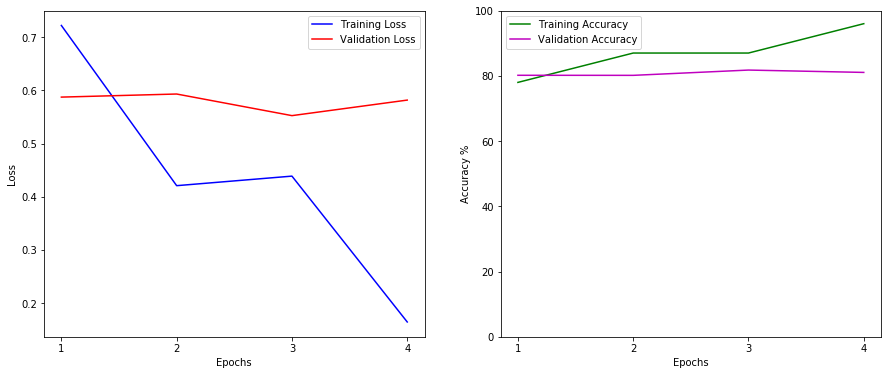


Epoch 5 of 5
Training	 Progress:	 0.000000 %	Loss: 0.619189	 Training Accuracy 75.00 %
Training	 Progress:	 1.597444 %	Loss: 0.522925	 Training Accuracy 75.00 %
Training	 Progress:	 3.194888 %	Loss: 0.351996	 Training Accuracy 84.00 %
Training	 Progress:	 4.792332 %	Loss: 0.431430	 Training Accuracy 87.00 %
Training	 Progress:	 6.389776 %	Loss: 0.250503	 Training Accuracy 93.00 %
Training	 Progress:	 7.987220 %	Loss: 0.353475	 Training Accuracy 90.00 %
Training	 Progress:	 9.584665 %	Loss: 0.592798	 Training Accuracy 78.00 %
Training	 Progress:	 11.182109 %	Loss: 0.503139	 Training Accuracy 75.00 %
Training	 Progress:	 12.779553 %	Loss: 0.428539	 Training Accuracy 84.00 %
Training	 Progress:	 14.376997 %	Loss: 0.272604	 Training Accuracy 93.00 %
Training	 Progress:	 15.974441 %	Loss: 0.344230	 Training Accuracy 87.00 %
Training	 Progress:	 17.571885 %	Loss: 0.441534	 Training Accuracy 84.00 %
Training	 Progress:	 19.169329 %	Loss: 0.302682	 Training Accuracy 90.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

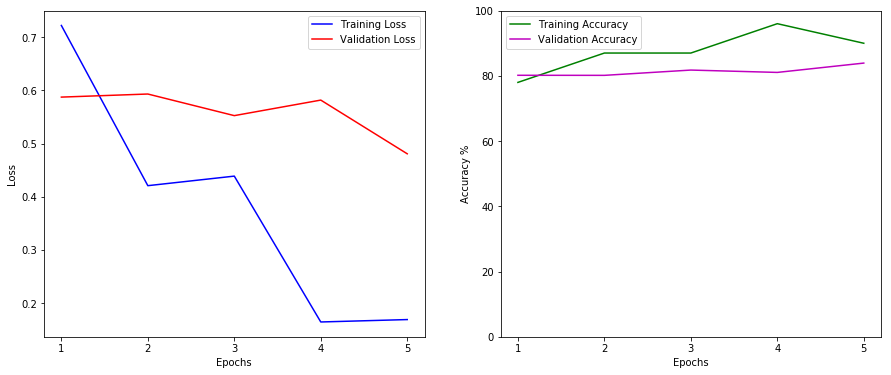

Round 0
testing accuracy 0.8392
Round 1

Epoch 1 of 5
Training	 Progress:	 0.000000 %	Loss: 0.270091	 Training Accuracy 90.00 %
Training	 Progress:	 1.453488 %	Loss: 0.305935	 Training Accuracy 93.00 %
Training	 Progress:	 2.906977 %	Loss: 0.598137	 Training Accuracy 81.00 %
Training	 Progress:	 4.360465 %	Loss: 0.336260	 Training Accuracy 84.00 %
Training	 Progress:	 5.813953 %	Loss: 0.722818	 Training Accuracy 71.00 %
Training	 Progress:	 7.267442 %	Loss: 0.256581	 Training Accuracy 93.00 %
Training	 Progress:	 8.720930 %	Loss: 0.350175	 Training Accuracy 87.00 %
Training	 Progress:	 10.174419 %	Loss: 0.489569	 Training Accuracy 75.00 %
Training	 Progress:	 11.627907 %	Loss: 0.177853	 Training Accuracy 93.00 %
Training	 Progress:	 13.081395 %	Loss: 0.540877	 Training Accuracy 81.00 %
Training	 Progress:	 14.534884 %	Loss: 0.591349	 Training Accuracy 87.00 %
Training	 Progress:	 15.988372 %	Loss: 0.306437	 Training Accuracy 87.00 %
Training	 Progress:	 17.441860 %	Loss: 0.983055	 Trai

<Figure size 432x288 with 0 Axes>

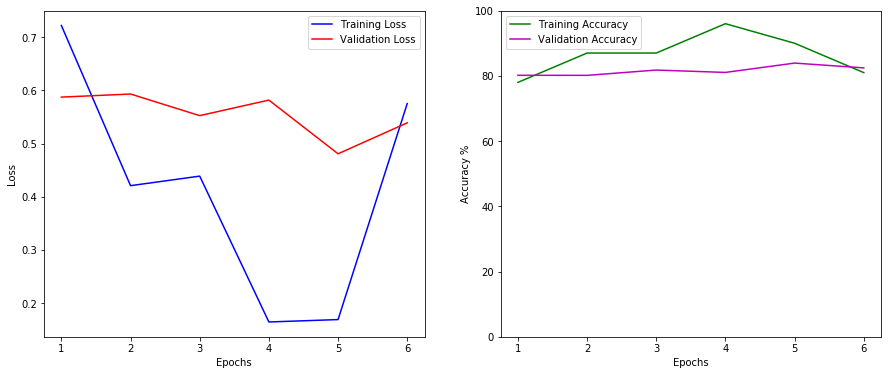


Epoch 2 of 5
Training	 Progress:	 0.000000 %	Loss: 0.348756	 Training Accuracy 84.00 %
Training	 Progress:	 1.453488 %	Loss: 0.882312	 Training Accuracy 56.00 %
Training	 Progress:	 2.906977 %	Loss: 0.384187	 Training Accuracy 87.00 %
Training	 Progress:	 4.360465 %	Loss: 0.069493	 Training Accuracy 100.00 %
Training	 Progress:	 5.813953 %	Loss: 0.450437	 Training Accuracy 78.00 %
Training	 Progress:	 7.267442 %	Loss: 0.372453	 Training Accuracy 81.00 %
Training	 Progress:	 8.720930 %	Loss: 0.494745	 Training Accuracy 87.00 %
Training	 Progress:	 10.174419 %	Loss: 0.436774	 Training Accuracy 84.00 %
Training	 Progress:	 11.627907 %	Loss: 0.510654	 Training Accuracy 78.00 %
Training	 Progress:	 13.081395 %	Loss: 0.403954	 Training Accuracy 87.00 %
Training	 Progress:	 14.534884 %	Loss: 0.217540	 Training Accuracy 90.00 %
Training	 Progress:	 15.988372 %	Loss: 0.380191	 Training Accuracy 87.00 %
Training	 Progress:	 17.441860 %	Loss: 0.337206	 Training Accuracy 81.00 %
Training	 Progres

<Figure size 432x288 with 0 Axes>

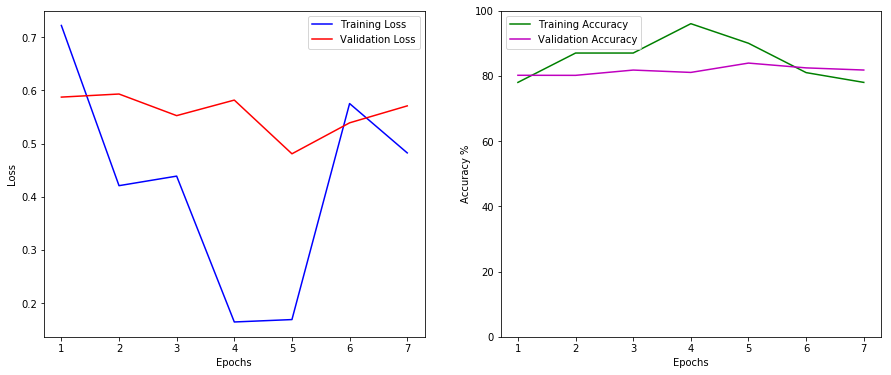


Epoch 3 of 5
Training	 Progress:	 0.000000 %	Loss: 0.160153	 Training Accuracy 90.00 %
Training	 Progress:	 1.453488 %	Loss: 0.353355	 Training Accuracy 90.00 %
Training	 Progress:	 2.906977 %	Loss: 0.428212	 Training Accuracy 81.00 %
Training	 Progress:	 4.360465 %	Loss: 0.230956	 Training Accuracy 87.00 %
Training	 Progress:	 5.813953 %	Loss: 0.191533	 Training Accuracy 90.00 %
Training	 Progress:	 7.267442 %	Loss: 0.584587	 Training Accuracy 84.00 %
Training	 Progress:	 8.720930 %	Loss: 0.550618	 Training Accuracy 78.00 %
Training	 Progress:	 10.174419 %	Loss: 0.605975	 Training Accuracy 84.00 %
Training	 Progress:	 11.627907 %	Loss: 0.290324	 Training Accuracy 90.00 %
Training	 Progress:	 13.081395 %	Loss: 0.366180	 Training Accuracy 90.00 %
Training	 Progress:	 14.534884 %	Loss: 0.303257	 Training Accuracy 90.00 %
Training	 Progress:	 15.988372 %	Loss: 0.433068	 Training Accuracy 84.00 %
Training	 Progress:	 17.441860 %	Loss: 0.034082	 Training Accuracy 100.00 %
Training	 Progres

<Figure size 432x288 with 0 Axes>

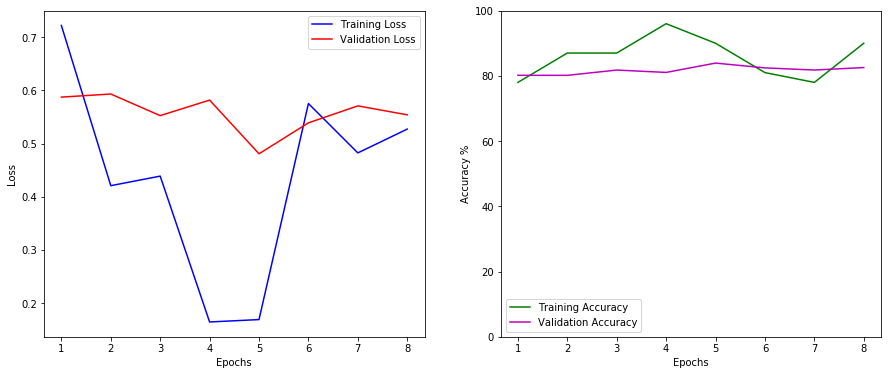


Epoch 4 of 5
Training	 Progress:	 0.000000 %	Loss: 0.215764	 Training Accuracy 90.00 %
Training	 Progress:	 1.453488 %	Loss: 0.099528	 Training Accuracy 96.00 %
Training	 Progress:	 2.906977 %	Loss: 0.442296	 Training Accuracy 81.00 %
Training	 Progress:	 4.360465 %	Loss: 0.060989	 Training Accuracy 100.00 %
Training	 Progress:	 5.813953 %	Loss: 0.137728	 Training Accuracy 100.00 %
Training	 Progress:	 7.267442 %	Loss: 0.453257	 Training Accuracy 90.00 %
Training	 Progress:	 8.720930 %	Loss: 0.451087	 Training Accuracy 87.00 %
Training	 Progress:	 10.174419 %	Loss: 0.289826	 Training Accuracy 96.00 %
Training	 Progress:	 11.627907 %	Loss: 0.278494	 Training Accuracy 87.00 %
Training	 Progress:	 13.081395 %	Loss: 0.387882	 Training Accuracy 90.00 %
Training	 Progress:	 14.534884 %	Loss: 0.243857	 Training Accuracy 93.00 %
Training	 Progress:	 15.988372 %	Loss: 0.335530	 Training Accuracy 84.00 %
Training	 Progress:	 17.441860 %	Loss: 0.243502	 Training Accuracy 87.00 %
Training	 Progre

<Figure size 432x288 with 0 Axes>

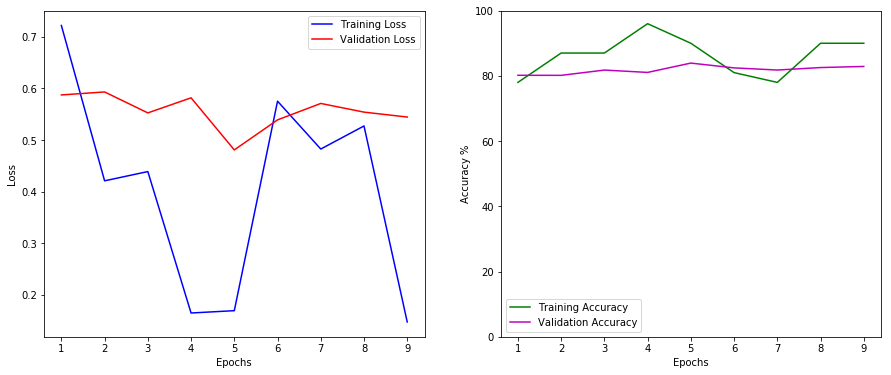


Epoch 5 of 5
Training	 Progress:	 0.000000 %	Loss: 0.461041	 Training Accuracy 81.00 %
Training	 Progress:	 1.453488 %	Loss: 0.517850	 Training Accuracy 81.00 %
Training	 Progress:	 2.906977 %	Loss: 0.143920	 Training Accuracy 93.00 %
Training	 Progress:	 4.360465 %	Loss: 0.330899	 Training Accuracy 87.00 %
Training	 Progress:	 5.813953 %	Loss: 0.246771	 Training Accuracy 93.00 %
Training	 Progress:	 7.267442 %	Loss: 0.559117	 Training Accuracy 78.00 %
Training	 Progress:	 8.720930 %	Loss: 0.170648	 Training Accuracy 96.00 %
Training	 Progress:	 10.174419 %	Loss: 0.243902	 Training Accuracy 90.00 %
Training	 Progress:	 11.627907 %	Loss: 0.257408	 Training Accuracy 93.00 %
Training	 Progress:	 13.081395 %	Loss: 0.211325	 Training Accuracy 93.00 %
Training	 Progress:	 14.534884 %	Loss: 0.366065	 Training Accuracy 96.00 %
Training	 Progress:	 15.988372 %	Loss: 0.279287	 Training Accuracy 87.00 %
Training	 Progress:	 17.441860 %	Loss: 0.271290	 Training Accuracy 87.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

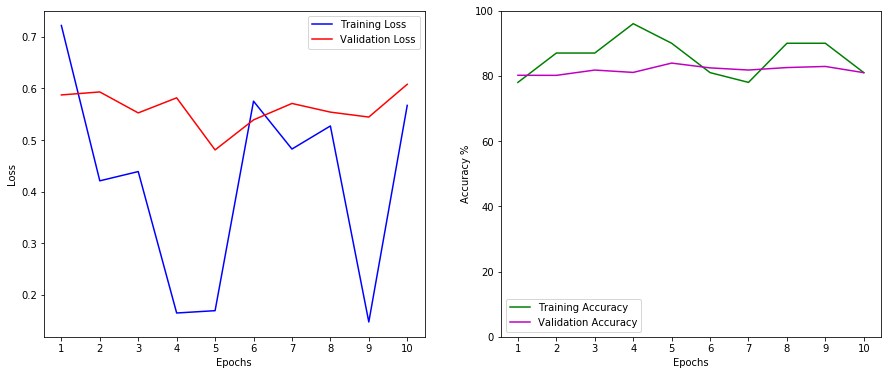

testing accuracy 0.8098
Graphs have been saved to: 2019-09-30T11:40:17 files


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

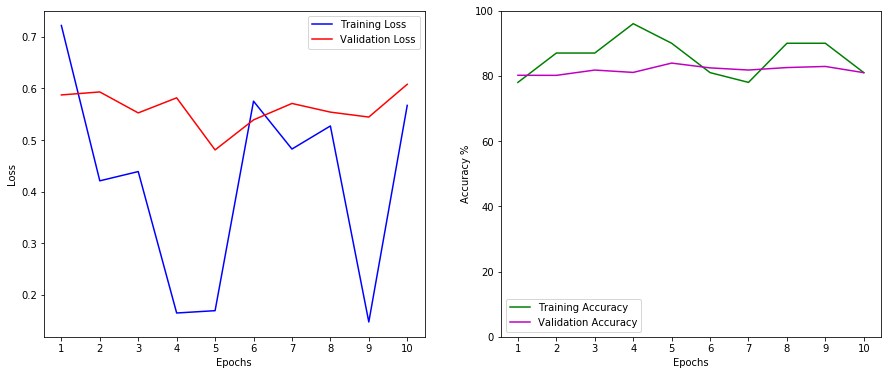

[tensor(0.7222, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.4209, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.4388, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.1645, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.1690, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.5753, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.4825, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.5273, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.1471, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.5672, device='cuda:0', grad_fn=<NllLossBackward>)]
[tensor(0.5874, device='cuda:0'), tensor(0.5932, device='cuda:0'), tensor(0.5526, device='cuda:0'), tensor(0.5818, device='cuda:0'), tensor(0.4808, device='cuda:0'), tensor(0.5391, device='cuda:0'), tensor(0.5709, device='cuda:0'), tensor(0.5541, device='cuda:0'), tensor(0.5445, device='cuda:0'), tensor(0.6081, device='cuda:0')]
[78, 87, 87, 96, 90, 81, 78, 90, 90, 81]
[80.18, 80.16, 81.78, 81.06

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /tmp/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth
100%|██████████| 4.79M/4.79M [00:00<00:00, 17.4MB/s]


<class 'torchvision.models.squeezenet.SqueezeNet'>
CIFAR10
SEED 1
RandomSampling
Test data set

Epoch 1 of 5
Training	 Progress:	 0.000000 %	Loss: 2.787365	 Training Accuracy 9.00 %
Training	 Progress:	 1.597444 %	Loss: 13.749424	 Training Accuracy 12.00 %
Training	 Progress:	 3.194888 %	Loss: 2.289894	 Training Accuracy 21.00 %
Training	 Progress:	 4.792332 %	Loss: 2.284316	 Training Accuracy 12.00 %
Training	 Progress:	 6.389776 %	Loss: 2.297022	 Training Accuracy 15.00 %
Training	 Progress:	 7.987220 %	Loss: 2.237765	 Training Accuracy 21.00 %
Training	 Progress:	 9.584665 %	Loss: 2.294636	 Training Accuracy 12.00 %
Training	 Progress:	 11.182109 %	Loss: 2.297104	 Training Accuracy 12.00 %
Training	 Progress:	 12.779553 %	Loss: 2.225821	 Training Accuracy 15.00 %
Training	 Progress:	 14.376997 %	Loss: 2.212579	 Training Accuracy 18.00 %
Training	 Progress:	 15.974441 %	Loss: 2.095809	 Training Accuracy 18.00 %
Training	 Progress:	 17.571885 %	Loss: 2.061180	 Training Accuracy 25.00 

<Figure size 432x288 with 0 Axes>

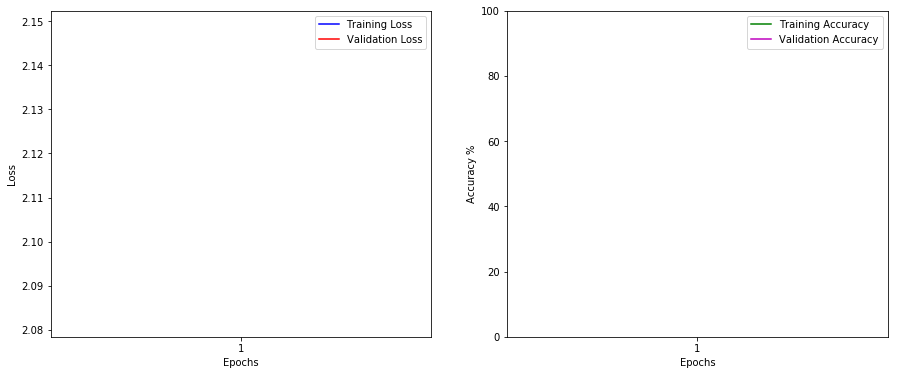


Epoch 2 of 5
Training	 Progress:	 0.000000 %	Loss: 1.797154	 Training Accuracy 31.00 %
Training	 Progress:	 1.597444 %	Loss: 2.159361	 Training Accuracy 18.00 %
Training	 Progress:	 3.194888 %	Loss: 1.873398	 Training Accuracy 34.00 %
Training	 Progress:	 4.792332 %	Loss: 2.307902	 Training Accuracy 9.00 %
Training	 Progress:	 6.389776 %	Loss: 2.261976	 Training Accuracy 15.00 %
Training	 Progress:	 7.987220 %	Loss: 2.096058	 Training Accuracy 18.00 %
Training	 Progress:	 9.584665 %	Loss: 2.073706	 Training Accuracy 25.00 %
Training	 Progress:	 11.182109 %	Loss: 2.034613	 Training Accuracy 21.00 %
Training	 Progress:	 12.779553 %	Loss: 2.046508	 Training Accuracy 21.00 %
Training	 Progress:	 14.376997 %	Loss: 1.647258	 Training Accuracy 40.00 %
Training	 Progress:	 15.974441 %	Loss: 2.005996	 Training Accuracy 28.00 %
Training	 Progress:	 17.571885 %	Loss: 1.964048	 Training Accuracy 31.00 %
Training	 Progress:	 19.169329 %	Loss: 2.132567	 Training Accuracy 18.00 %
Training	 Progress:

<Figure size 432x288 with 0 Axes>

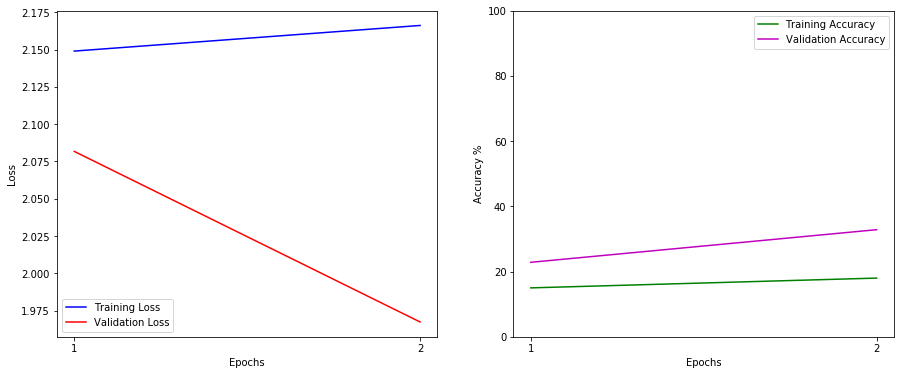


Epoch 3 of 5
Training	 Progress:	 0.000000 %	Loss: 1.729742	 Training Accuracy 43.00 %
Training	 Progress:	 1.597444 %	Loss: 1.732103	 Training Accuracy 40.00 %
Training	 Progress:	 3.194888 %	Loss: 1.835896	 Training Accuracy 34.00 %
Training	 Progress:	 4.792332 %	Loss: 2.289712	 Training Accuracy 15.00 %
Training	 Progress:	 6.389776 %	Loss: 1.774276	 Training Accuracy 40.00 %
Training	 Progress:	 7.987220 %	Loss: 1.833235	 Training Accuracy 43.00 %
Training	 Progress:	 9.584665 %	Loss: 1.654545	 Training Accuracy 37.00 %
Training	 Progress:	 11.182109 %	Loss: 2.035686	 Training Accuracy 21.00 %
Training	 Progress:	 12.779553 %	Loss: 1.831048	 Training Accuracy 37.00 %
Training	 Progress:	 14.376997 %	Loss: 2.042491	 Training Accuracy 28.00 %
Training	 Progress:	 15.974441 %	Loss: 2.021524	 Training Accuracy 31.00 %
Training	 Progress:	 17.571885 %	Loss: 2.047380	 Training Accuracy 18.00 %
Training	 Progress:	 19.169329 %	Loss: 1.815276	 Training Accuracy 34.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

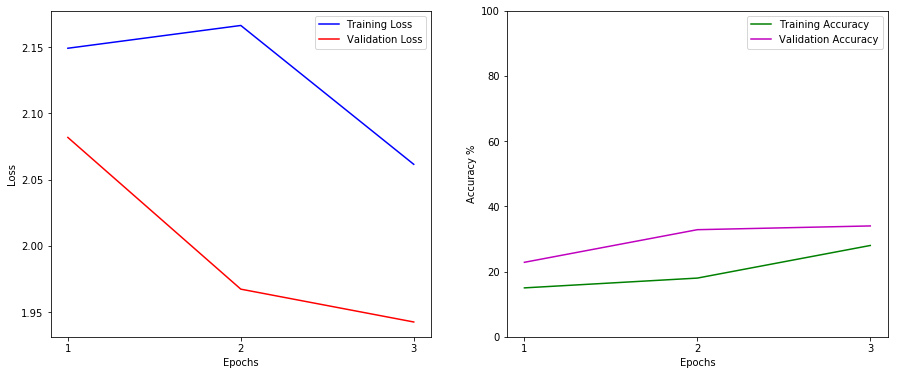


Epoch 4 of 5
Training	 Progress:	 0.000000 %	Loss: 1.590534	 Training Accuracy 50.00 %
Training	 Progress:	 1.597444 %	Loss: 1.839217	 Training Accuracy 34.00 %
Training	 Progress:	 3.194888 %	Loss: 1.897281	 Training Accuracy 28.00 %
Training	 Progress:	 4.792332 %	Loss: 2.111499	 Training Accuracy 25.00 %
Training	 Progress:	 6.389776 %	Loss: 1.941421	 Training Accuracy 31.00 %
Training	 Progress:	 7.987220 %	Loss: 1.877413	 Training Accuracy 34.00 %
Training	 Progress:	 9.584665 %	Loss: 2.038526	 Training Accuracy 25.00 %
Training	 Progress:	 11.182109 %	Loss: 1.609760	 Training Accuracy 46.00 %
Training	 Progress:	 12.779553 %	Loss: 1.566468	 Training Accuracy 43.00 %
Training	 Progress:	 14.376997 %	Loss: 1.871299	 Training Accuracy 34.00 %
Training	 Progress:	 15.974441 %	Loss: 1.929175	 Training Accuracy 31.00 %
Training	 Progress:	 17.571885 %	Loss: 1.772301	 Training Accuracy 40.00 %
Training	 Progress:	 19.169329 %	Loss: 1.551872	 Training Accuracy 50.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

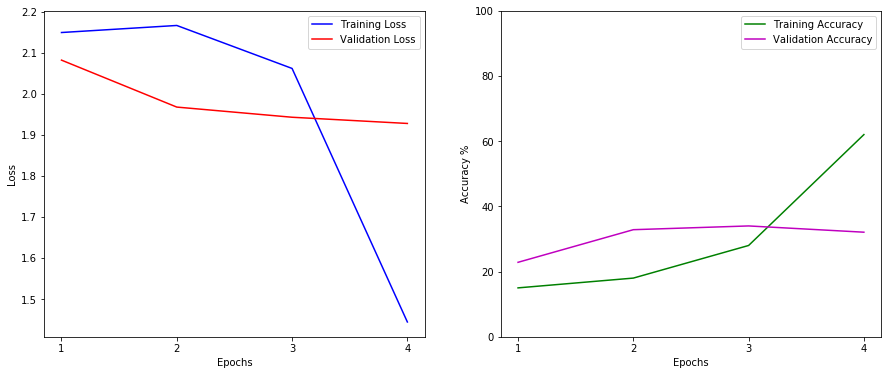


Epoch 5 of 5
Training	 Progress:	 0.000000 %	Loss: 1.777791	 Training Accuracy 37.00 %
Training	 Progress:	 1.597444 %	Loss: 1.922539	 Training Accuracy 37.00 %
Training	 Progress:	 3.194888 %	Loss: 1.821508	 Training Accuracy 34.00 %
Training	 Progress:	 4.792332 %	Loss: 1.591036	 Training Accuracy 43.00 %
Training	 Progress:	 6.389776 %	Loss: 1.572424	 Training Accuracy 53.00 %
Training	 Progress:	 7.987220 %	Loss: 1.657870	 Training Accuracy 46.00 %
Training	 Progress:	 9.584665 %	Loss: 1.640554	 Training Accuracy 50.00 %
Training	 Progress:	 11.182109 %	Loss: 2.146424	 Training Accuracy 18.00 %
Training	 Progress:	 12.779553 %	Loss: 1.606344	 Training Accuracy 43.00 %
Training	 Progress:	 14.376997 %	Loss: 1.767341	 Training Accuracy 37.00 %
Training	 Progress:	 15.974441 %	Loss: 1.618679	 Training Accuracy 50.00 %
Training	 Progress:	 17.571885 %	Loss: 1.684083	 Training Accuracy 43.00 %
Training	 Progress:	 19.169329 %	Loss: 1.348300	 Training Accuracy 53.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

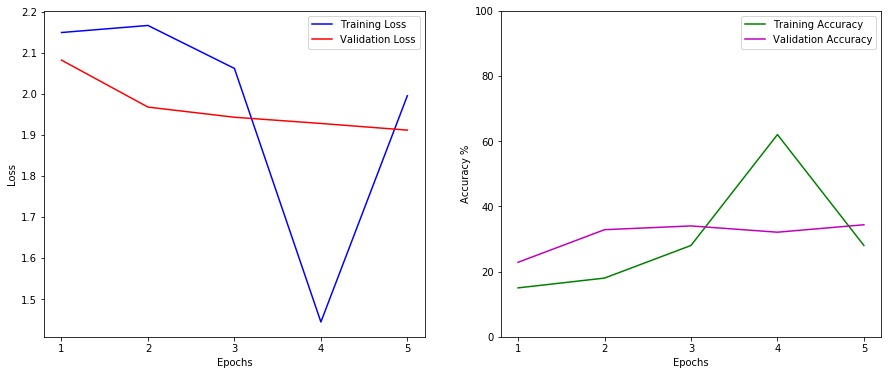

Round 0
testing accuracy 0.3435
Round 1

Epoch 1 of 5
Training	 Progress:	 0.000000 %	Loss: 1.838257	 Training Accuracy 31.00 %
Training	 Progress:	 1.453488 %	Loss: 1.828410	 Training Accuracy 31.00 %
Training	 Progress:	 2.906977 %	Loss: 2.070925	 Training Accuracy 25.00 %
Training	 Progress:	 4.360465 %	Loss: 1.954328	 Training Accuracy 28.00 %
Training	 Progress:	 5.813953 %	Loss: 1.632897	 Training Accuracy 46.00 %
Training	 Progress:	 7.267442 %	Loss: 1.626761	 Training Accuracy 40.00 %
Training	 Progress:	 8.720930 %	Loss: 1.807001	 Training Accuracy 37.00 %
Training	 Progress:	 10.174419 %	Loss: 1.751238	 Training Accuracy 40.00 %
Training	 Progress:	 11.627907 %	Loss: 1.724971	 Training Accuracy 34.00 %
Training	 Progress:	 13.081395 %	Loss: 1.557557	 Training Accuracy 50.00 %
Training	 Progress:	 14.534884 %	Loss: 1.902373	 Training Accuracy 31.00 %
Training	 Progress:	 15.988372 %	Loss: 2.023384	 Training Accuracy 28.00 %
Training	 Progress:	 17.441860 %	Loss: 1.896797	 Trai

<Figure size 432x288 with 0 Axes>

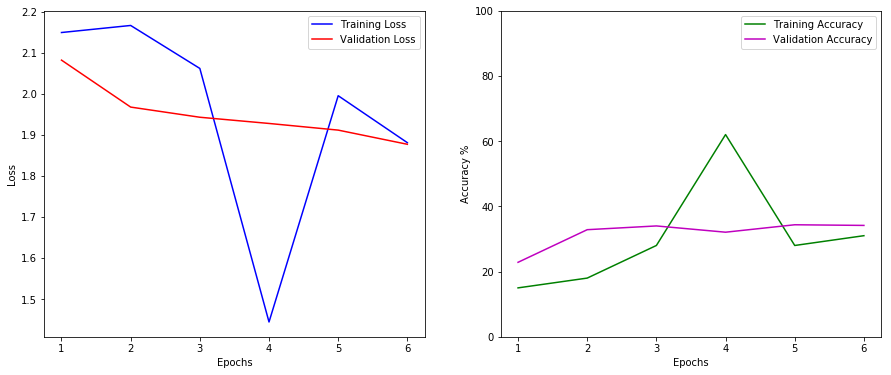


Epoch 2 of 5
Training	 Progress:	 0.000000 %	Loss: 1.502847	 Training Accuracy 53.00 %
Training	 Progress:	 1.453488 %	Loss: 1.950859	 Training Accuracy 31.00 %
Training	 Progress:	 2.906977 %	Loss: 1.645264	 Training Accuracy 43.00 %
Training	 Progress:	 4.360465 %	Loss: 2.115118	 Training Accuracy 28.00 %
Training	 Progress:	 5.813953 %	Loss: 1.594872	 Training Accuracy 43.00 %
Training	 Progress:	 7.267442 %	Loss: 1.788330	 Training Accuracy 34.00 %
Training	 Progress:	 8.720930 %	Loss: 1.669926	 Training Accuracy 37.00 %
Training	 Progress:	 10.174419 %	Loss: 1.818398	 Training Accuracy 37.00 %
Training	 Progress:	 11.627907 %	Loss: 1.721534	 Training Accuracy 37.00 %
Training	 Progress:	 13.081395 %	Loss: 1.739048	 Training Accuracy 43.00 %
Training	 Progress:	 14.534884 %	Loss: 1.808852	 Training Accuracy 34.00 %
Training	 Progress:	 15.988372 %	Loss: 1.954072	 Training Accuracy 31.00 %
Training	 Progress:	 17.441860 %	Loss: 1.955064	 Training Accuracy 28.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

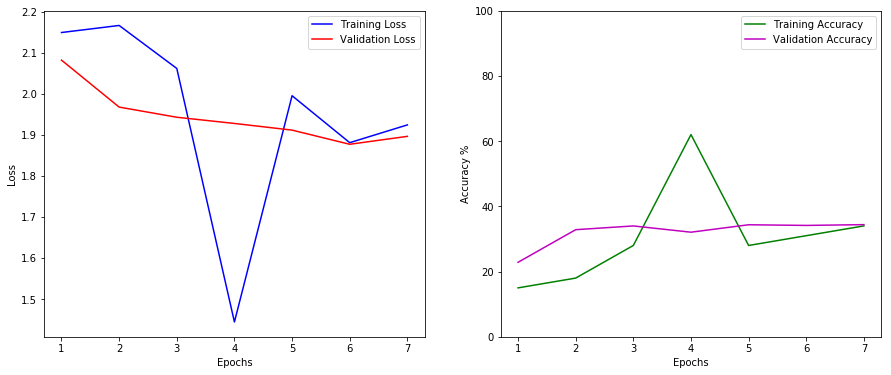


Epoch 3 of 5
Training	 Progress:	 0.000000 %	Loss: 2.028525	 Training Accuracy 25.00 %
Training	 Progress:	 1.453488 %	Loss: 1.669849	 Training Accuracy 43.00 %
Training	 Progress:	 2.906977 %	Loss: 2.052117	 Training Accuracy 28.00 %
Training	 Progress:	 4.360465 %	Loss: 1.681190	 Training Accuracy 40.00 %
Training	 Progress:	 5.813953 %	Loss: 1.635353	 Training Accuracy 43.00 %
Training	 Progress:	 7.267442 %	Loss: 1.768366	 Training Accuracy 43.00 %
Training	 Progress:	 8.720930 %	Loss: 1.911254	 Training Accuracy 28.00 %
Training	 Progress:	 10.174419 %	Loss: 1.902164	 Training Accuracy 37.00 %
Training	 Progress:	 11.627907 %	Loss: 1.922486	 Training Accuracy 28.00 %
Training	 Progress:	 13.081395 %	Loss: 1.839590	 Training Accuracy 28.00 %
Training	 Progress:	 14.534884 %	Loss: 1.993173	 Training Accuracy 25.00 %
Training	 Progress:	 15.988372 %	Loss: 1.683745	 Training Accuracy 31.00 %
Training	 Progress:	 17.441860 %	Loss: 1.780382	 Training Accuracy 40.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

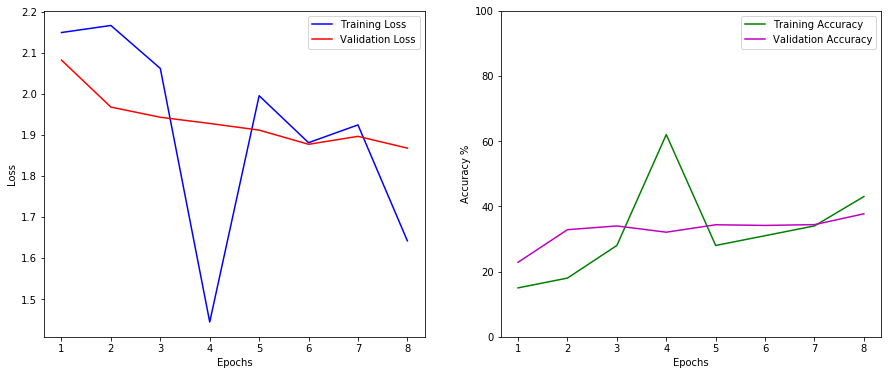


Epoch 4 of 5
Training	 Progress:	 0.000000 %	Loss: 1.684919	 Training Accuracy 43.00 %
Training	 Progress:	 1.453488 %	Loss: 1.609042	 Training Accuracy 37.00 %
Training	 Progress:	 2.906977 %	Loss: 1.537274	 Training Accuracy 43.00 %
Training	 Progress:	 4.360465 %	Loss: 1.987737	 Training Accuracy 37.00 %
Training	 Progress:	 5.813953 %	Loss: 1.827429	 Training Accuracy 40.00 %
Training	 Progress:	 7.267442 %	Loss: 1.556630	 Training Accuracy 46.00 %
Training	 Progress:	 8.720930 %	Loss: 1.987028	 Training Accuracy 34.00 %
Training	 Progress:	 10.174419 %	Loss: 1.708567	 Training Accuracy 40.00 %
Training	 Progress:	 11.627907 %	Loss: 1.796777	 Training Accuracy 37.00 %
Training	 Progress:	 13.081395 %	Loss: 1.813868	 Training Accuracy 28.00 %
Training	 Progress:	 14.534884 %	Loss: 1.952210	 Training Accuracy 25.00 %
Training	 Progress:	 15.988372 %	Loss: 1.637153	 Training Accuracy 46.00 %
Training	 Progress:	 17.441860 %	Loss: 2.017555	 Training Accuracy 40.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

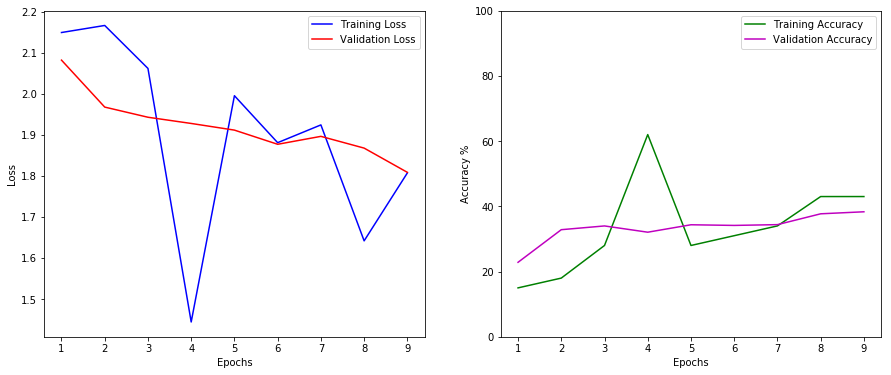


Epoch 5 of 5
Training	 Progress:	 0.000000 %	Loss: 1.605887	 Training Accuracy 50.00 %
Training	 Progress:	 1.453488 %	Loss: 1.759478	 Training Accuracy 46.00 %
Training	 Progress:	 2.906977 %	Loss: 1.834560	 Training Accuracy 40.00 %
Training	 Progress:	 4.360465 %	Loss: 1.558367	 Training Accuracy 53.00 %
Training	 Progress:	 5.813953 %	Loss: 1.965103	 Training Accuracy 28.00 %
Training	 Progress:	 7.267442 %	Loss: 1.653652	 Training Accuracy 37.00 %
Training	 Progress:	 8.720930 %	Loss: 1.570566	 Training Accuracy 43.00 %
Training	 Progress:	 10.174419 %	Loss: 1.544014	 Training Accuracy 46.00 %
Training	 Progress:	 11.627907 %	Loss: 1.766302	 Training Accuracy 43.00 %
Training	 Progress:	 13.081395 %	Loss: 1.617047	 Training Accuracy 40.00 %
Training	 Progress:	 14.534884 %	Loss: 1.435495	 Training Accuracy 59.00 %
Training	 Progress:	 15.988372 %	Loss: 1.781984	 Training Accuracy 34.00 %
Training	 Progress:	 17.441860 %	Loss: 1.500372	 Training Accuracy 46.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

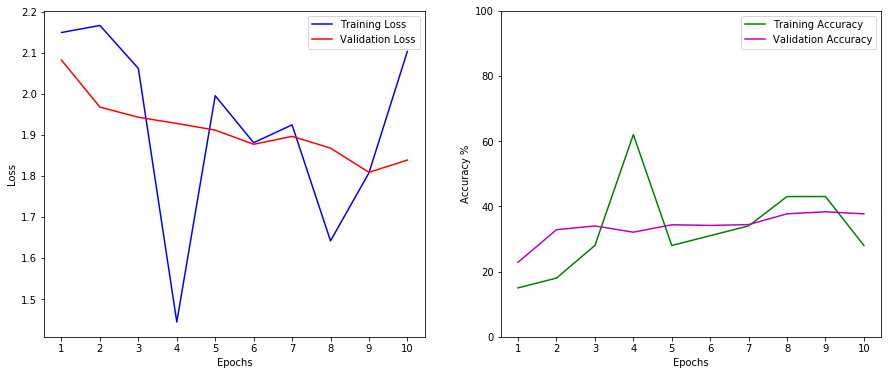

testing accuracy 0.377
Graphs have been saved to: 2019-09-30T11:49:37 files


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

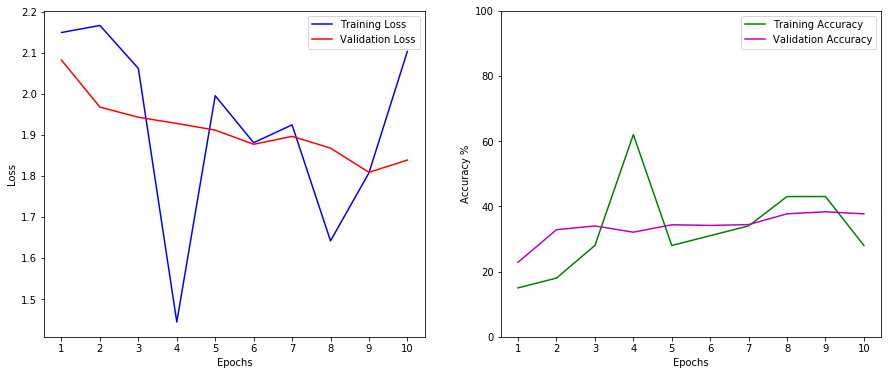

[tensor(2.1490, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.1662, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.0615, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4439, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.9951, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8807, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.9240, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.6416, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8070, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.1030, device='cuda:0', grad_fn=<NllLossBackward>)]
[tensor(2.0818, device='cuda:0'), tensor(1.9674, device='cuda:0'), tensor(1.9426, device='cuda:0'), tensor(1.9275, device='cuda:0'), tensor(1.9113, device='cuda:0'), tensor(1.8768, device='cuda:0'), tensor(1.8961, device='cuda:0'), tensor(1.8675, device='cuda:0'), tensor(1.8084, device='cuda:0'), tensor(1.8383, device='cuda:0')]
[15, 18, 28, 62, 28, 31, 34, 43, 43, 28]
[22.84, 32.84, 33.99, 32.07

<Figure size 432x288 with 0 Axes>

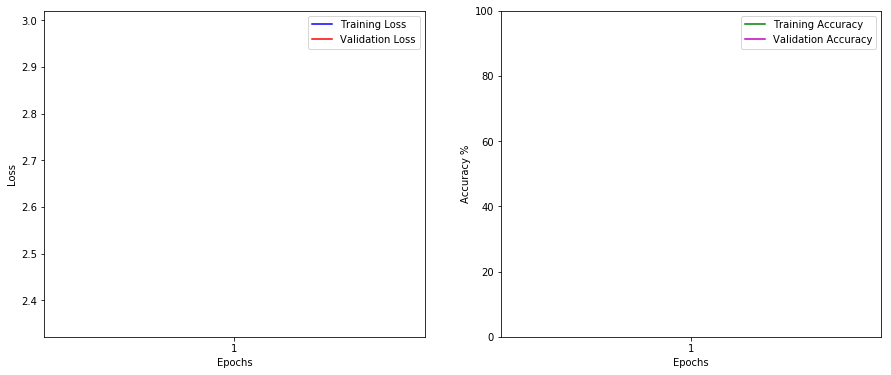


Epoch 2 of 5
Training	 Progress:	 0.000000 %	Loss: 2.634040	 Training Accuracy 9.00 %
Training	 Progress:	 1.597444 %	Loss: 2.382893	 Training Accuracy 15.00 %
Training	 Progress:	 3.194888 %	Loss: 2.165760	 Training Accuracy 28.00 %
Training	 Progress:	 4.792332 %	Loss: 1.722417	 Training Accuracy 40.00 %
Training	 Progress:	 6.389776 %	Loss: 2.373846	 Training Accuracy 31.00 %
Training	 Progress:	 7.987220 %	Loss: 2.723410	 Training Accuracy 21.00 %
Training	 Progress:	 9.584665 %	Loss: 2.637529	 Training Accuracy 25.00 %
Training	 Progress:	 11.182109 %	Loss: 1.812976	 Training Accuracy 28.00 %
Training	 Progress:	 12.779553 %	Loss: 1.920985	 Training Accuracy 34.00 %
Training	 Progress:	 14.376997 %	Loss: 2.412333	 Training Accuracy 28.00 %
Training	 Progress:	 15.974441 %	Loss: 1.911540	 Training Accuracy 28.00 %
Training	 Progress:	 17.571885 %	Loss: 2.308278	 Training Accuracy 28.00 %
Training	 Progress:	 19.169329 %	Loss: 2.053144	 Training Accuracy 15.00 %
Training	 Progress:

<Figure size 432x288 with 0 Axes>

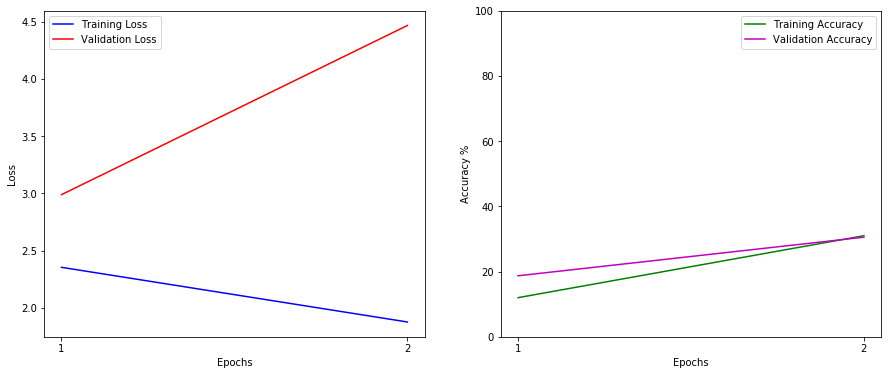


Epoch 3 of 5
Training	 Progress:	 0.000000 %	Loss: 1.718001	 Training Accuracy 21.00 %
Training	 Progress:	 1.597444 %	Loss: 2.009037	 Training Accuracy 28.00 %
Training	 Progress:	 3.194888 %	Loss: 1.916030	 Training Accuracy 43.00 %
Training	 Progress:	 4.792332 %	Loss: 1.896137	 Training Accuracy 28.00 %
Training	 Progress:	 6.389776 %	Loss: 2.424045	 Training Accuracy 25.00 %
Training	 Progress:	 7.987220 %	Loss: 1.830022	 Training Accuracy 37.00 %
Training	 Progress:	 9.584665 %	Loss: 2.220815	 Training Accuracy 31.00 %
Training	 Progress:	 11.182109 %	Loss: 1.623185	 Training Accuracy 40.00 %
Training	 Progress:	 12.779553 %	Loss: 1.781463	 Training Accuracy 40.00 %
Training	 Progress:	 14.376997 %	Loss: 1.950684	 Training Accuracy 28.00 %
Training	 Progress:	 15.974441 %	Loss: 2.189513	 Training Accuracy 34.00 %
Training	 Progress:	 17.571885 %	Loss: 1.701506	 Training Accuracy 34.00 %
Training	 Progress:	 19.169329 %	Loss: 1.650597	 Training Accuracy 34.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

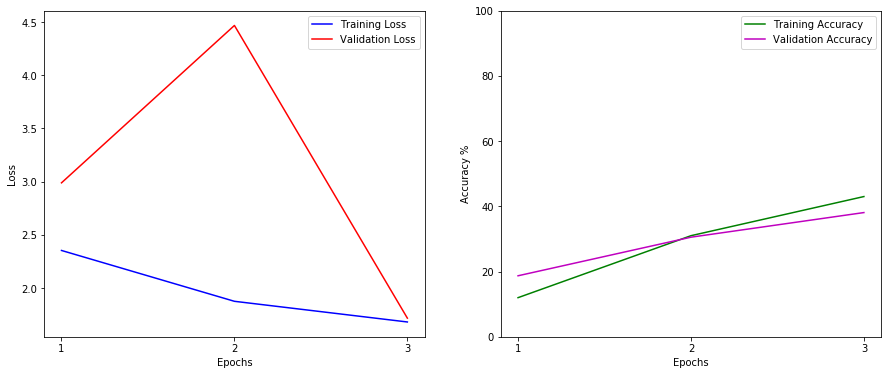


Epoch 4 of 5
Training	 Progress:	 0.000000 %	Loss: 1.525224	 Training Accuracy 43.00 %
Training	 Progress:	 1.597444 %	Loss: 1.738636	 Training Accuracy 40.00 %
Training	 Progress:	 3.194888 %	Loss: 1.826833	 Training Accuracy 46.00 %
Training	 Progress:	 4.792332 %	Loss: 1.443046	 Training Accuracy 46.00 %
Training	 Progress:	 6.389776 %	Loss: 1.832930	 Training Accuracy 34.00 %
Training	 Progress:	 7.987220 %	Loss: 1.882097	 Training Accuracy 37.00 %
Training	 Progress:	 9.584665 %	Loss: 1.678656	 Training Accuracy 31.00 %
Training	 Progress:	 11.182109 %	Loss: 1.986511	 Training Accuracy 40.00 %
Training	 Progress:	 12.779553 %	Loss: 1.663534	 Training Accuracy 40.00 %
Training	 Progress:	 14.376997 %	Loss: 1.225616	 Training Accuracy 50.00 %
Training	 Progress:	 15.974441 %	Loss: 2.595979	 Training Accuracy 21.00 %
Training	 Progress:	 17.571885 %	Loss: 1.672938	 Training Accuracy 34.00 %
Training	 Progress:	 19.169329 %	Loss: 1.515574	 Training Accuracy 46.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

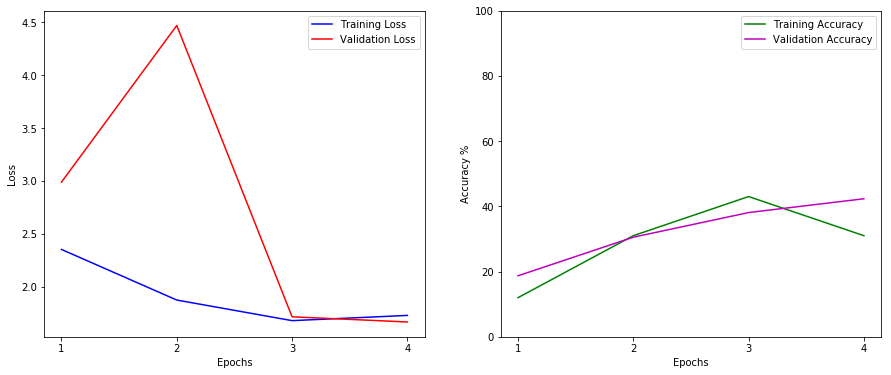


Epoch 5 of 5
Training	 Progress:	 0.000000 %	Loss: 1.348489	 Training Accuracy 56.00 %
Training	 Progress:	 1.597444 %	Loss: 1.801462	 Training Accuracy 43.00 %
Training	 Progress:	 3.194888 %	Loss: 1.706361	 Training Accuracy 34.00 %
Training	 Progress:	 4.792332 %	Loss: 1.743531	 Training Accuracy 37.00 %
Training	 Progress:	 6.389776 %	Loss: 1.644361	 Training Accuracy 46.00 %
Training	 Progress:	 7.987220 %	Loss: 1.669125	 Training Accuracy 50.00 %
Training	 Progress:	 9.584665 %	Loss: 1.792937	 Training Accuracy 34.00 %
Training	 Progress:	 11.182109 %	Loss: 1.854462	 Training Accuracy 34.00 %
Training	 Progress:	 12.779553 %	Loss: 1.638981	 Training Accuracy 37.00 %
Training	 Progress:	 14.376997 %	Loss: 1.690461	 Training Accuracy 34.00 %
Training	 Progress:	 15.974441 %	Loss: 1.158083	 Training Accuracy 65.00 %
Training	 Progress:	 17.571885 %	Loss: 1.603557	 Training Accuracy 56.00 %
Training	 Progress:	 19.169329 %	Loss: 1.603961	 Training Accuracy 59.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

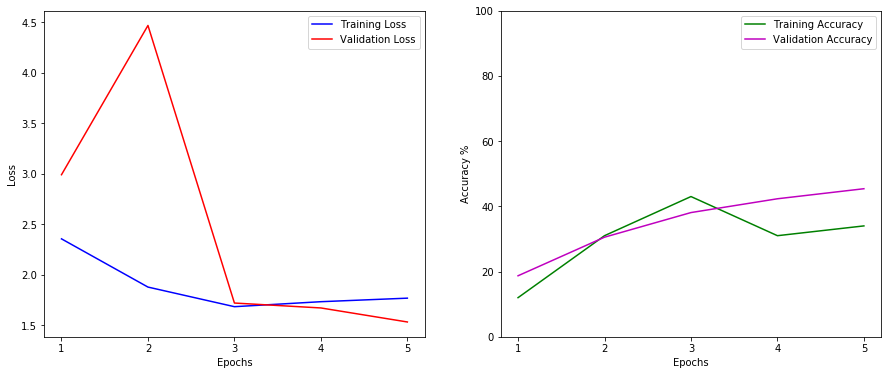

Round 0
testing accuracy 0.454
Round 1

Epoch 1 of 5
Training	 Progress:	 0.000000 %	Loss: 1.297726	 Training Accuracy 37.00 %
Training	 Progress:	 1.453488 %	Loss: 1.583125	 Training Accuracy 40.00 %
Training	 Progress:	 2.906977 %	Loss: 1.706173	 Training Accuracy 40.00 %
Training	 Progress:	 4.360465 %	Loss: 1.402816	 Training Accuracy 62.00 %
Training	 Progress:	 5.813953 %	Loss: 1.482073	 Training Accuracy 50.00 %
Training	 Progress:	 7.267442 %	Loss: 1.568092	 Training Accuracy 50.00 %
Training	 Progress:	 8.720930 %	Loss: 1.438175	 Training Accuracy 46.00 %
Training	 Progress:	 10.174419 %	Loss: 1.381485	 Training Accuracy 46.00 %
Training	 Progress:	 11.627907 %	Loss: 1.707798	 Training Accuracy 31.00 %
Training	 Progress:	 13.081395 %	Loss: 1.623554	 Training Accuracy 53.00 %
Training	 Progress:	 14.534884 %	Loss: 1.580487	 Training Accuracy 50.00 %
Training	 Progress:	 15.988372 %	Loss: 1.154227	 Training Accuracy 53.00 %
Training	 Progress:	 17.441860 %	Loss: 1.301670	 Train

<Figure size 432x288 with 0 Axes>

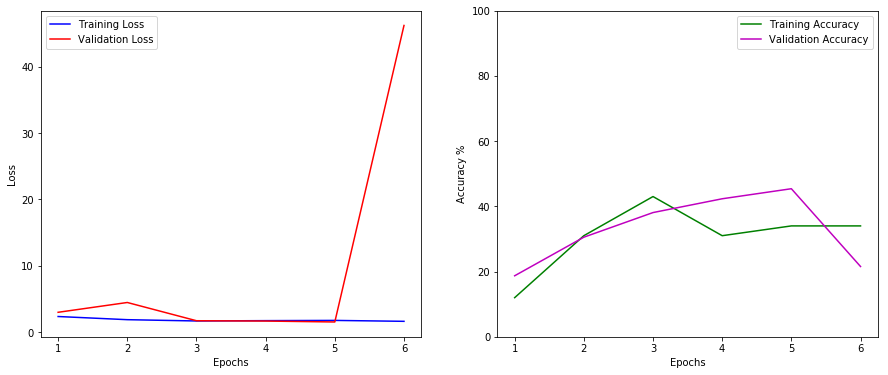


Epoch 2 of 5
Training	 Progress:	 0.000000 %	Loss: 1.891906	 Training Accuracy 53.00 %
Training	 Progress:	 1.453488 %	Loss: 1.247502	 Training Accuracy 53.00 %
Training	 Progress:	 2.906977 %	Loss: 1.830889	 Training Accuracy 46.00 %
Training	 Progress:	 4.360465 %	Loss: 1.558877	 Training Accuracy 40.00 %
Training	 Progress:	 5.813953 %	Loss: 1.393806	 Training Accuracy 46.00 %
Training	 Progress:	 7.267442 %	Loss: 1.513235	 Training Accuracy 50.00 %
Training	 Progress:	 8.720930 %	Loss: 0.987025	 Training Accuracy 68.00 %
Training	 Progress:	 10.174419 %	Loss: 1.230847	 Training Accuracy 53.00 %
Training	 Progress:	 11.627907 %	Loss: 1.183062	 Training Accuracy 53.00 %
Training	 Progress:	 13.081395 %	Loss: 1.060381	 Training Accuracy 56.00 %
Training	 Progress:	 14.534884 %	Loss: 1.224684	 Training Accuracy 59.00 %
Training	 Progress:	 15.988372 %	Loss: 1.709011	 Training Accuracy 40.00 %
Training	 Progress:	 17.441860 %	Loss: 1.325027	 Training Accuracy 50.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

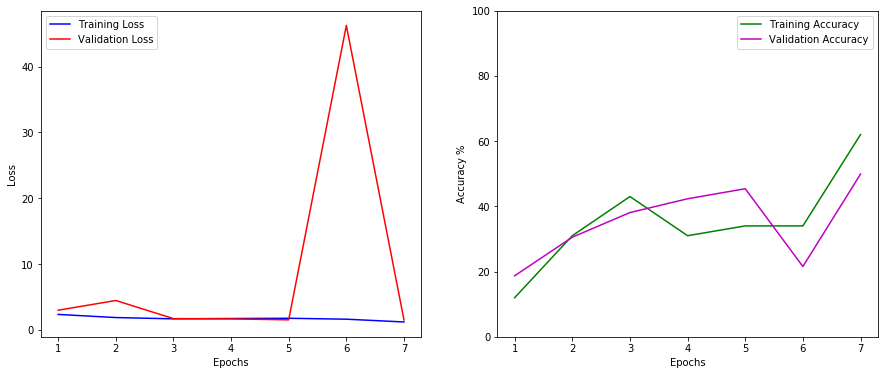


Epoch 3 of 5
Training	 Progress:	 0.000000 %	Loss: 1.216042	 Training Accuracy 53.00 %
Training	 Progress:	 1.453488 %	Loss: 1.182678	 Training Accuracy 56.00 %
Training	 Progress:	 2.906977 %	Loss: 1.267975	 Training Accuracy 40.00 %
Training	 Progress:	 4.360465 %	Loss: 1.674475	 Training Accuracy 31.00 %
Training	 Progress:	 5.813953 %	Loss: 0.976004	 Training Accuracy 68.00 %
Training	 Progress:	 7.267442 %	Loss: 1.484877	 Training Accuracy 43.00 %
Training	 Progress:	 8.720930 %	Loss: 1.507854	 Training Accuracy 46.00 %
Training	 Progress:	 10.174419 %	Loss: 1.256909	 Training Accuracy 53.00 %
Training	 Progress:	 11.627907 %	Loss: 0.870255	 Training Accuracy 78.00 %
Training	 Progress:	 13.081395 %	Loss: 0.831446	 Training Accuracy 68.00 %
Training	 Progress:	 14.534884 %	Loss: 1.488343	 Training Accuracy 56.00 %
Training	 Progress:	 15.988372 %	Loss: 1.582263	 Training Accuracy 50.00 %
Training	 Progress:	 17.441860 %	Loss: 0.956430	 Training Accuracy 65.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

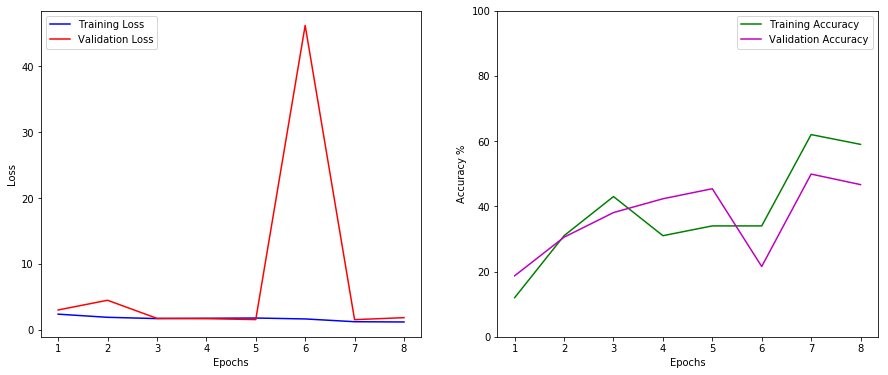


Epoch 4 of 5
Training	 Progress:	 0.000000 %	Loss: 1.441875	 Training Accuracy 62.00 %
Training	 Progress:	 1.453488 %	Loss: 1.336140	 Training Accuracy 43.00 %
Training	 Progress:	 2.906977 %	Loss: 1.394382	 Training Accuracy 46.00 %
Training	 Progress:	 4.360465 %	Loss: 1.188350	 Training Accuracy 50.00 %
Training	 Progress:	 5.813953 %	Loss: 1.176260	 Training Accuracy 56.00 %
Training	 Progress:	 7.267442 %	Loss: 1.277239	 Training Accuracy 53.00 %
Training	 Progress:	 8.720930 %	Loss: 1.322054	 Training Accuracy 56.00 %
Training	 Progress:	 10.174419 %	Loss: 1.403969	 Training Accuracy 53.00 %
Training	 Progress:	 11.627907 %	Loss: 1.728308	 Training Accuracy 37.00 %
Training	 Progress:	 13.081395 %	Loss: 1.415607	 Training Accuracy 56.00 %
Training	 Progress:	 14.534884 %	Loss: 1.067767	 Training Accuracy 59.00 %
Training	 Progress:	 15.988372 %	Loss: 0.948895	 Training Accuracy 68.00 %
Training	 Progress:	 17.441860 %	Loss: 1.239250	 Training Accuracy 59.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

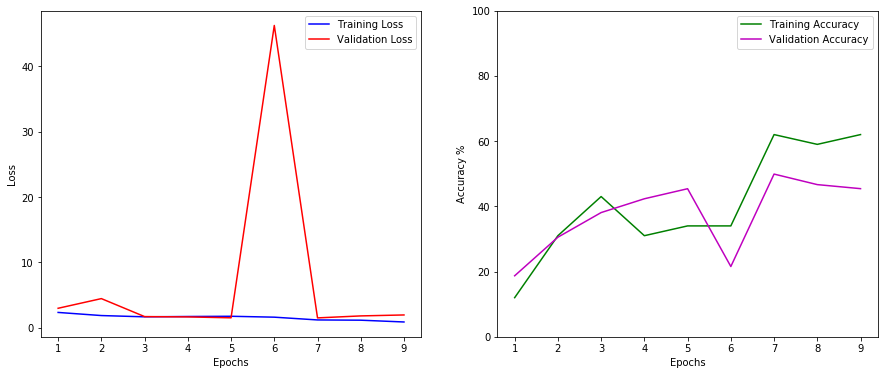


Epoch 5 of 5
Training	 Progress:	 0.000000 %	Loss: 1.588285	 Training Accuracy 43.00 %
Training	 Progress:	 1.453488 %	Loss: 1.170152	 Training Accuracy 65.00 %
Training	 Progress:	 2.906977 %	Loss: 1.196144	 Training Accuracy 53.00 %
Training	 Progress:	 4.360465 %	Loss: 0.905437	 Training Accuracy 59.00 %
Training	 Progress:	 5.813953 %	Loss: 0.983668	 Training Accuracy 56.00 %
Training	 Progress:	 7.267442 %	Loss: 1.251395	 Training Accuracy 59.00 %
Training	 Progress:	 8.720930 %	Loss: 1.109016	 Training Accuracy 68.00 %
Training	 Progress:	 10.174419 %	Loss: 1.113490	 Training Accuracy 62.00 %
Training	 Progress:	 11.627907 %	Loss: 0.839925	 Training Accuracy 65.00 %
Training	 Progress:	 13.081395 %	Loss: 1.163943	 Training Accuracy 56.00 %
Training	 Progress:	 14.534884 %	Loss: 0.957590	 Training Accuracy 65.00 %
Training	 Progress:	 15.988372 %	Loss: 0.972090	 Training Accuracy 68.00 %
Training	 Progress:	 17.441860 %	Loss: 1.032916	 Training Accuracy 65.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

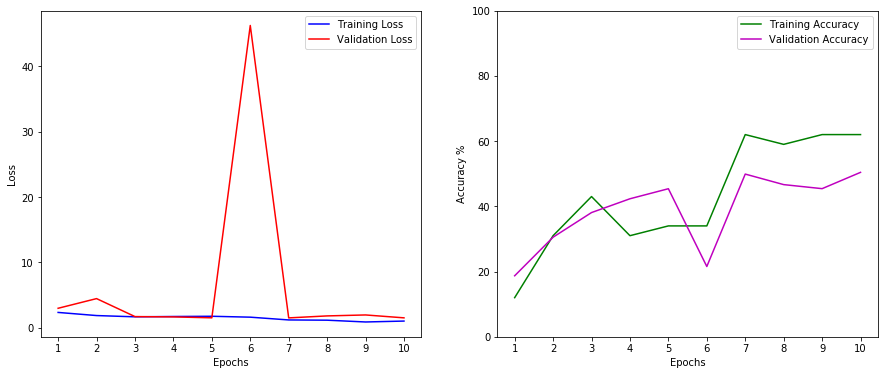

testing accuracy 0.5042
Graphs have been saved to: 2019-09-30T12:47:05 files


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

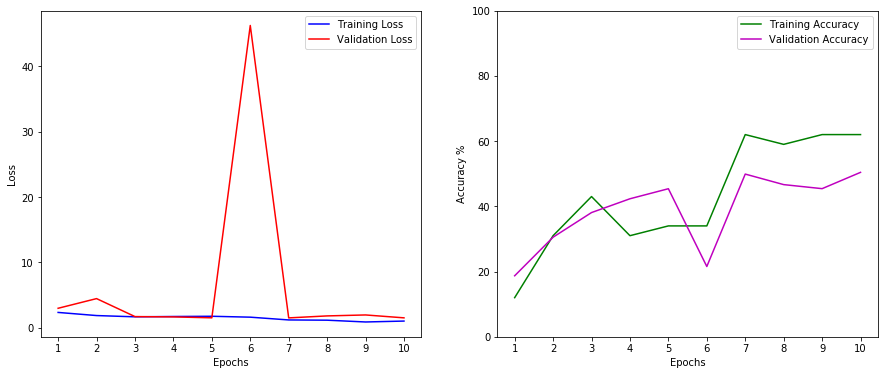

[tensor(2.3533, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8756, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.6813, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.7307, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.7657, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.6281, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.2049, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1660, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.8938, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.0327, device='cuda:0', grad_fn=<NllLossBackward>)]
[tensor(2.9886, device='cuda:0'), tensor(4.4674, device='cuda:0'), tensor(1.7174, device='cuda:0'), tensor(1.6687, device='cuda:0'), tensor(1.5298, device='cuda:0'), tensor(46.2341, device='cuda:0'), tensor(1.5177, device='cuda:0'), tensor(1.8211, device='cuda:0'), tensor(1.9673, device='cuda:0'), tensor(1.5256, device='cuda:0')]
[12, 31, 43, 31, 34, 34, 62, 59, 62, 62]
[18.71, 30.54, 38.09, 42.3

<Figure size 432x288 with 0 Axes>

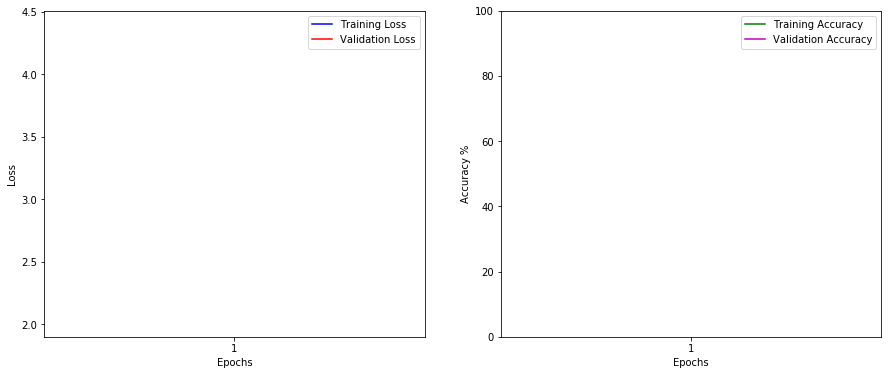


Epoch 2 of 5
Training	 Progress:	 0.000000 %	Loss: 1.809984	 Training Accuracy 31.00 %
Training	 Progress:	 1.597444 %	Loss: 1.444903	 Training Accuracy 43.00 %
Training	 Progress:	 3.194888 %	Loss: 1.851852	 Training Accuracy 46.00 %
Training	 Progress:	 4.792332 %	Loss: 2.109900	 Training Accuracy 28.00 %
Training	 Progress:	 6.389776 %	Loss: 1.683469	 Training Accuracy 40.00 %
Training	 Progress:	 7.987220 %	Loss: 1.691605	 Training Accuracy 40.00 %
Training	 Progress:	 9.584665 %	Loss: 1.901114	 Training Accuracy 28.00 %
Training	 Progress:	 11.182109 %	Loss: 1.609369	 Training Accuracy 37.00 %
Training	 Progress:	 12.779553 %	Loss: 1.944419	 Training Accuracy 15.00 %
Training	 Progress:	 14.376997 %	Loss: 1.834441	 Training Accuracy 37.00 %
Training	 Progress:	 15.974441 %	Loss: 2.349235	 Training Accuracy 21.00 %
Training	 Progress:	 17.571885 %	Loss: 1.234674	 Training Accuracy 53.00 %
Training	 Progress:	 19.169329 %	Loss: 1.867717	 Training Accuracy 31.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

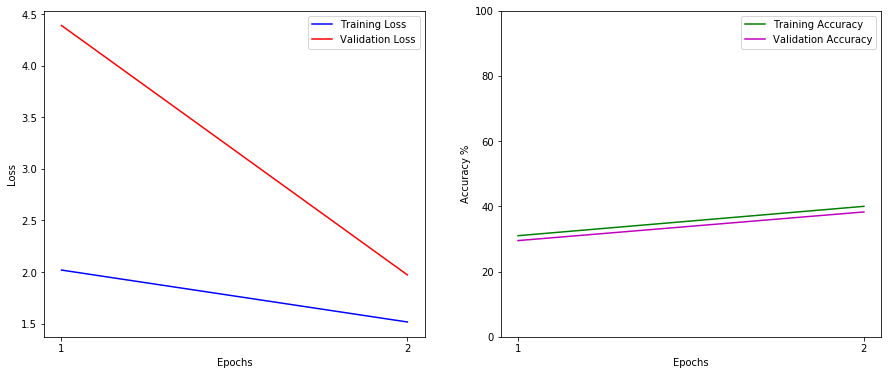


Epoch 3 of 5
Training	 Progress:	 0.000000 %	Loss: 1.711143	 Training Accuracy 37.00 %
Training	 Progress:	 1.597444 %	Loss: 1.630704	 Training Accuracy 43.00 %
Training	 Progress:	 3.194888 %	Loss: 1.491406	 Training Accuracy 43.00 %
Training	 Progress:	 4.792332 %	Loss: 1.458112	 Training Accuracy 53.00 %
Training	 Progress:	 6.389776 %	Loss: 1.531688	 Training Accuracy 40.00 %
Training	 Progress:	 7.987220 %	Loss: 1.220010	 Training Accuracy 56.00 %
Training	 Progress:	 9.584665 %	Loss: 1.562383	 Training Accuracy 37.00 %
Training	 Progress:	 11.182109 %	Loss: 1.493534	 Training Accuracy 46.00 %
Training	 Progress:	 12.779553 %	Loss: 1.511425	 Training Accuracy 37.00 %
Training	 Progress:	 14.376997 %	Loss: 1.534053	 Training Accuracy 37.00 %
Training	 Progress:	 15.974441 %	Loss: 1.354393	 Training Accuracy 59.00 %
Training	 Progress:	 17.571885 %	Loss: 1.438031	 Training Accuracy 46.00 %
Training	 Progress:	 19.169329 %	Loss: 1.534582	 Training Accuracy 50.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

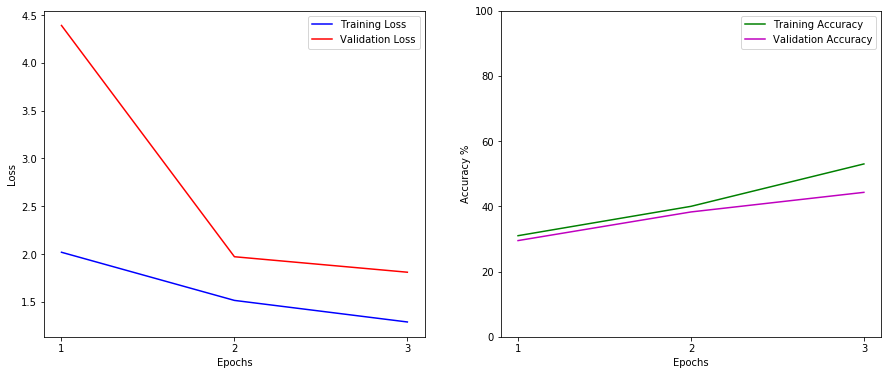


Epoch 4 of 5
Training	 Progress:	 0.000000 %	Loss: 1.484398	 Training Accuracy 43.00 %
Training	 Progress:	 1.597444 %	Loss: 1.102574	 Training Accuracy 56.00 %
Training	 Progress:	 3.194888 %	Loss: 1.522889	 Training Accuracy 46.00 %
Training	 Progress:	 4.792332 %	Loss: 1.353332	 Training Accuracy 43.00 %
Training	 Progress:	 6.389776 %	Loss: 1.079229	 Training Accuracy 56.00 %
Training	 Progress:	 7.987220 %	Loss: 1.372887	 Training Accuracy 46.00 %
Training	 Progress:	 9.584665 %	Loss: 1.458529	 Training Accuracy 43.00 %
Training	 Progress:	 11.182109 %	Loss: 1.350646	 Training Accuracy 50.00 %
Training	 Progress:	 12.779553 %	Loss: 1.137037	 Training Accuracy 53.00 %
Training	 Progress:	 14.376997 %	Loss: 1.581330	 Training Accuracy 46.00 %
Training	 Progress:	 15.974441 %	Loss: 0.858075	 Training Accuracy 68.00 %
Training	 Progress:	 17.571885 %	Loss: 0.984804	 Training Accuracy 65.00 %
Training	 Progress:	 19.169329 %	Loss: 1.489589	 Training Accuracy 46.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

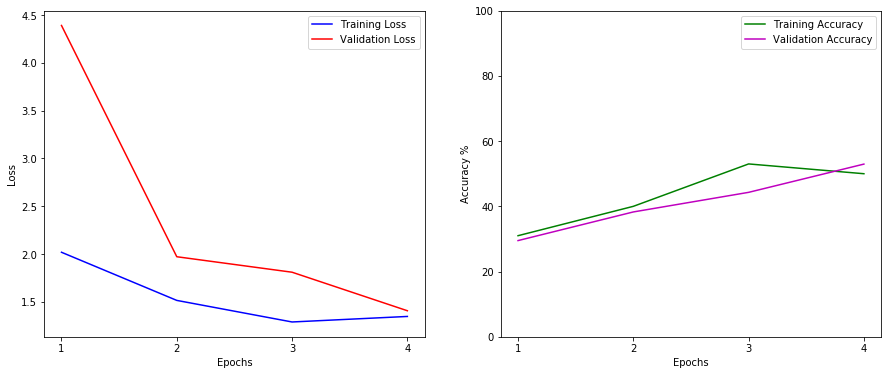


Epoch 5 of 5
Training	 Progress:	 0.000000 %	Loss: 1.594411	 Training Accuracy 43.00 %
Training	 Progress:	 1.597444 %	Loss: 1.454740	 Training Accuracy 37.00 %
Training	 Progress:	 3.194888 %	Loss: 1.218159	 Training Accuracy 53.00 %
Training	 Progress:	 4.792332 %	Loss: 0.899570	 Training Accuracy 65.00 %
Training	 Progress:	 6.389776 %	Loss: 0.873941	 Training Accuracy 71.00 %
Training	 Progress:	 7.987220 %	Loss: 1.129057	 Training Accuracy 46.00 %
Training	 Progress:	 9.584665 %	Loss: 1.390424	 Training Accuracy 46.00 %
Training	 Progress:	 11.182109 %	Loss: 1.061385	 Training Accuracy 56.00 %
Training	 Progress:	 12.779553 %	Loss: 1.049013	 Training Accuracy 68.00 %
Training	 Progress:	 14.376997 %	Loss: 1.247171	 Training Accuracy 46.00 %
Training	 Progress:	 15.974441 %	Loss: 1.174078	 Training Accuracy 65.00 %
Training	 Progress:	 17.571885 %	Loss: 1.462507	 Training Accuracy 59.00 %
Training	 Progress:	 19.169329 %	Loss: 0.928188	 Training Accuracy 68.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

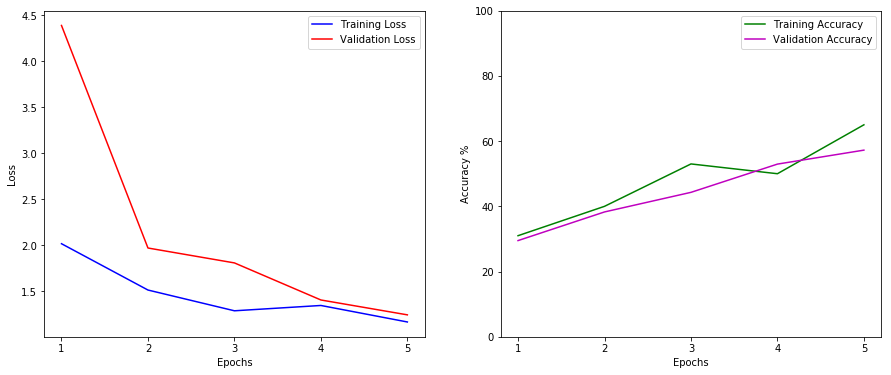

Round 0
testing accuracy 0.5723
Round 1

Epoch 1 of 5
Training	 Progress:	 0.000000 %	Loss: 0.729768	 Training Accuracy 75.00 %
Training	 Progress:	 1.453488 %	Loss: 0.770831	 Training Accuracy 65.00 %
Training	 Progress:	 2.906977 %	Loss: 1.277353	 Training Accuracy 56.00 %
Training	 Progress:	 4.360465 %	Loss: 0.920460	 Training Accuracy 62.00 %
Training	 Progress:	 5.813953 %	Loss: 1.583340	 Training Accuracy 46.00 %
Training	 Progress:	 7.267442 %	Loss: 1.100044	 Training Accuracy 59.00 %
Training	 Progress:	 8.720930 %	Loss: 1.279300	 Training Accuracy 59.00 %
Training	 Progress:	 10.174419 %	Loss: 1.249915	 Training Accuracy 46.00 %
Training	 Progress:	 11.627907 %	Loss: 0.675868	 Training Accuracy 81.00 %
Training	 Progress:	 13.081395 %	Loss: 1.234724	 Training Accuracy 59.00 %
Training	 Progress:	 14.534884 %	Loss: 1.236252	 Training Accuracy 56.00 %
Training	 Progress:	 15.988372 %	Loss: 1.004348	 Training Accuracy 62.00 %
Training	 Progress:	 17.441860 %	Loss: 1.037484	 Trai

<Figure size 432x288 with 0 Axes>

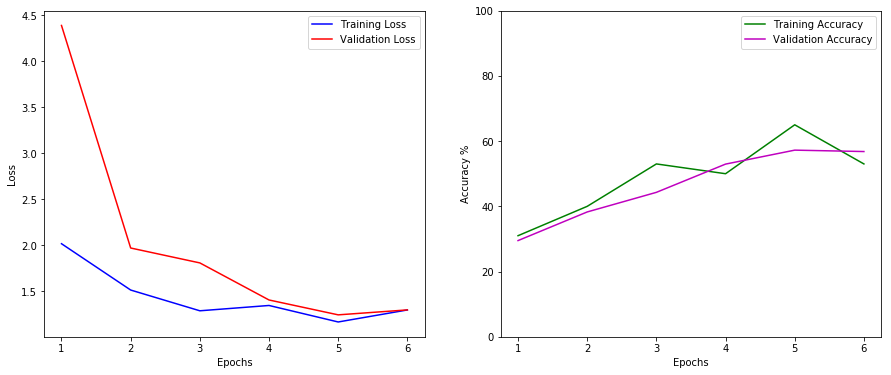


Epoch 2 of 5
Training	 Progress:	 0.000000 %	Loss: 0.714008	 Training Accuracy 65.00 %
Training	 Progress:	 1.453488 %	Loss: 1.364303	 Training Accuracy 56.00 %
Training	 Progress:	 2.906977 %	Loss: 0.579691	 Training Accuracy 81.00 %
Training	 Progress:	 4.360465 %	Loss: 0.418268	 Training Accuracy 90.00 %
Training	 Progress:	 5.813953 %	Loss: 0.824575	 Training Accuracy 71.00 %
Training	 Progress:	 7.267442 %	Loss: 0.867833	 Training Accuracy 65.00 %
Training	 Progress:	 8.720930 %	Loss: 1.088760	 Training Accuracy 59.00 %
Training	 Progress:	 10.174419 %	Loss: 1.604792	 Training Accuracy 40.00 %
Training	 Progress:	 11.627907 %	Loss: 1.116145	 Training Accuracy 62.00 %
Training	 Progress:	 13.081395 %	Loss: 0.951492	 Training Accuracy 68.00 %
Training	 Progress:	 14.534884 %	Loss: 0.935340	 Training Accuracy 68.00 %
Training	 Progress:	 15.988372 %	Loss: 0.932009	 Training Accuracy 68.00 %
Training	 Progress:	 17.441860 %	Loss: 1.004767	 Training Accuracy 62.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

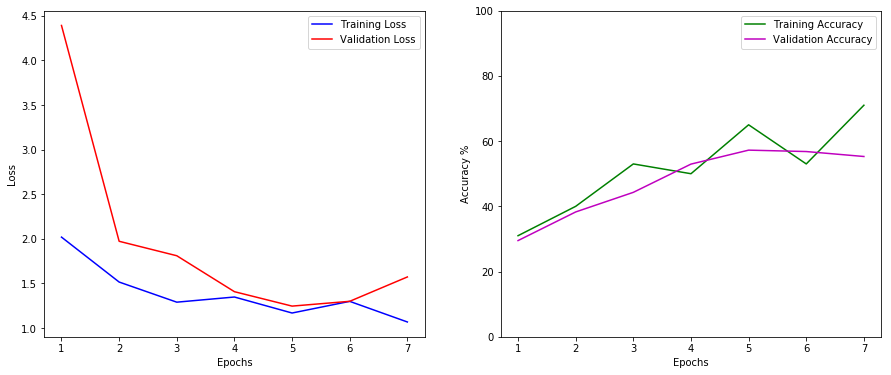


Epoch 3 of 5
Training	 Progress:	 0.000000 %	Loss: 0.925509	 Training Accuracy 65.00 %
Training	 Progress:	 1.453488 %	Loss: 0.678932	 Training Accuracy 78.00 %
Training	 Progress:	 2.906977 %	Loss: 1.099026	 Training Accuracy 65.00 %
Training	 Progress:	 4.360465 %	Loss: 0.707789	 Training Accuracy 68.00 %
Training	 Progress:	 5.813953 %	Loss: 0.572194	 Training Accuracy 81.00 %
Training	 Progress:	 7.267442 %	Loss: 0.979969	 Training Accuracy 75.00 %
Training	 Progress:	 8.720930 %	Loss: 0.842164	 Training Accuracy 71.00 %
Training	 Progress:	 10.174419 %	Loss: 1.152325	 Training Accuracy 59.00 %
Training	 Progress:	 11.627907 %	Loss: 0.818079	 Training Accuracy 65.00 %
Training	 Progress:	 13.081395 %	Loss: 0.680983	 Training Accuracy 81.00 %
Training	 Progress:	 14.534884 %	Loss: 0.875320	 Training Accuracy 68.00 %
Training	 Progress:	 15.988372 %	Loss: 1.215883	 Training Accuracy 62.00 %
Training	 Progress:	 17.441860 %	Loss: 0.532619	 Training Accuracy 87.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

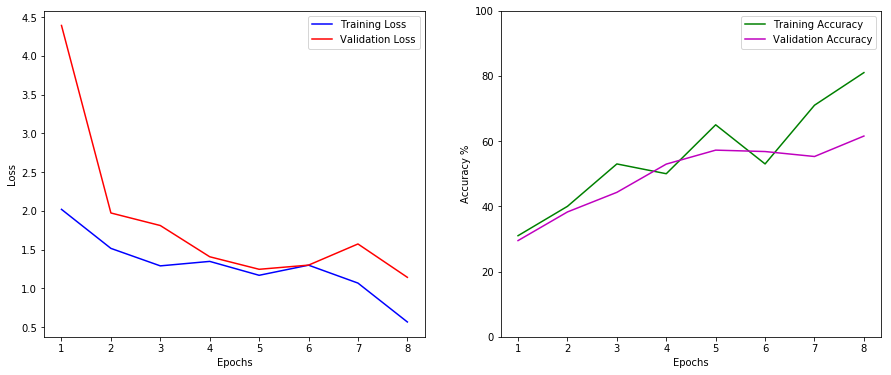


Epoch 4 of 5
Training	 Progress:	 0.000000 %	Loss: 0.492234	 Training Accuracy 81.00 %
Training	 Progress:	 1.453488 %	Loss: 0.511019	 Training Accuracy 75.00 %
Training	 Progress:	 2.906977 %	Loss: 0.596463	 Training Accuracy 78.00 %
Training	 Progress:	 4.360465 %	Loss: 0.327253	 Training Accuracy 87.00 %
Training	 Progress:	 5.813953 %	Loss: 0.685377	 Training Accuracy 71.00 %
Training	 Progress:	 7.267442 %	Loss: 1.062631	 Training Accuracy 71.00 %
Training	 Progress:	 8.720930 %	Loss: 0.567517	 Training Accuracy 81.00 %
Training	 Progress:	 10.174419 %	Loss: 0.713803	 Training Accuracy 75.00 %
Training	 Progress:	 11.627907 %	Loss: 0.468620	 Training Accuracy 87.00 %
Training	 Progress:	 13.081395 %	Loss: 0.663577	 Training Accuracy 81.00 %
Training	 Progress:	 14.534884 %	Loss: 0.498884	 Training Accuracy 78.00 %
Training	 Progress:	 15.988372 %	Loss: 0.662584	 Training Accuracy 84.00 %
Training	 Progress:	 17.441860 %	Loss: 0.657392	 Training Accuracy 75.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

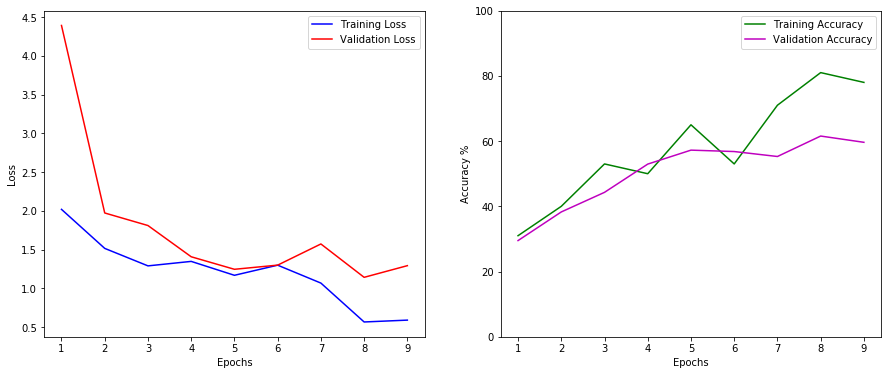


Epoch 5 of 5
Training	 Progress:	 0.000000 %	Loss: 0.623626	 Training Accuracy 75.00 %
Training	 Progress:	 1.453488 %	Loss: 0.602715	 Training Accuracy 78.00 %
Training	 Progress:	 2.906977 %	Loss: 0.316996	 Training Accuracy 90.00 %
Training	 Progress:	 4.360465 %	Loss: 0.595892	 Training Accuracy 81.00 %
Training	 Progress:	 5.813953 %	Loss: 0.463921	 Training Accuracy 78.00 %
Training	 Progress:	 7.267442 %	Loss: 0.699899	 Training Accuracy 75.00 %
Training	 Progress:	 8.720930 %	Loss: 0.349580	 Training Accuracy 87.00 %
Training	 Progress:	 10.174419 %	Loss: 0.614265	 Training Accuracy 78.00 %
Training	 Progress:	 11.627907 %	Loss: 0.348010	 Training Accuracy 87.00 %
Training	 Progress:	 13.081395 %	Loss: 0.500643	 Training Accuracy 81.00 %
Training	 Progress:	 14.534884 %	Loss: 0.488637	 Training Accuracy 81.00 %
Training	 Progress:	 15.988372 %	Loss: 0.633398	 Training Accuracy 75.00 %
Training	 Progress:	 17.441860 %	Loss: 0.359589	 Training Accuracy 84.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

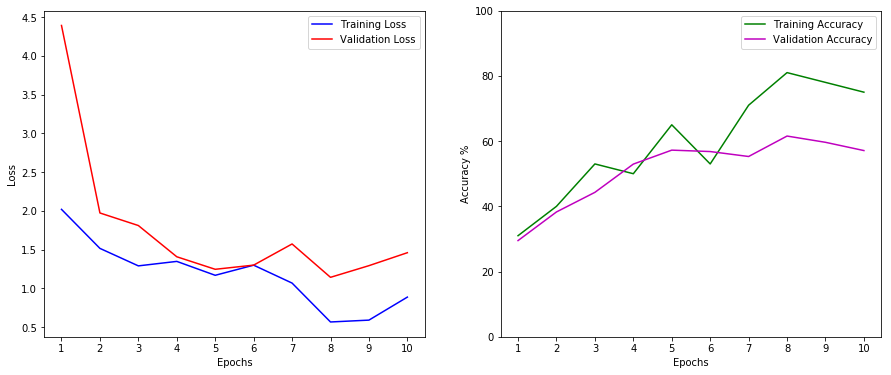

testing accuracy 0.571
Graphs have been saved to: 2019-09-30T14:21:54 files


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

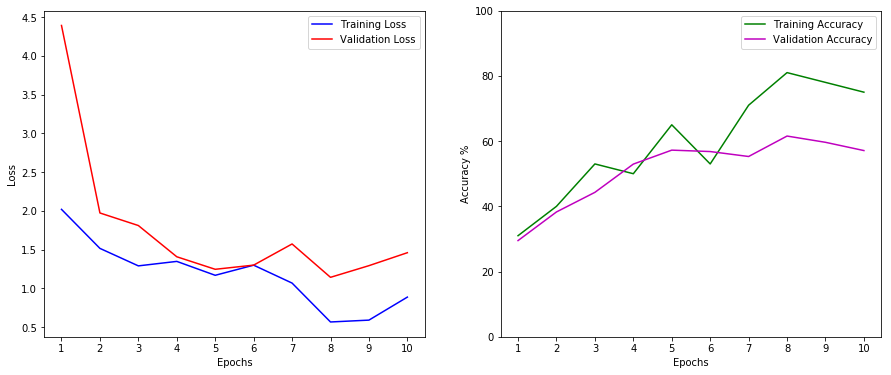

[tensor(2.0188, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.5152, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.2896, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.3474, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1680, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.2986, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.0676, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.5657, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.5896, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.8866, device='cuda:0', grad_fn=<NllLossBackward>)]
[tensor(4.3915, device='cuda:0'), tensor(1.9721, device='cuda:0'), tensor(1.8101, device='cuda:0'), tensor(1.4071, device='cuda:0'), tensor(1.2454, device='cuda:0'), tensor(1.2992, device='cuda:0'), tensor(1.5722, device='cuda:0'), tensor(1.1418, device='cuda:0'), tensor(1.2923, device='cuda:0'), tensor(1.4595, device='cuda:0')]
[31, 40, 53, 50, 65, 53, 71, 81, 78, 75]
[29.5, 38.28, 44.29, 52.95,

<Figure size 432x288 with 0 Axes>

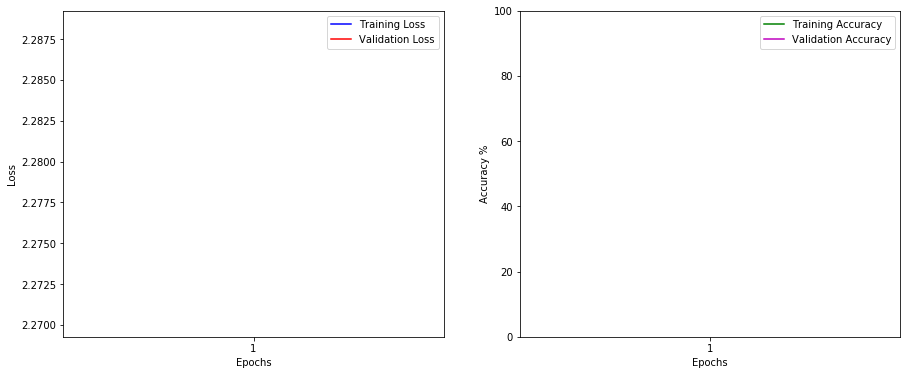


Epoch 2 of 5
Training	 Progress:	 0.000000 %	Loss: 2.304202	 Training Accuracy 9.00 %
Training	 Progress:	 1.597444 %	Loss: 2.295086	 Training Accuracy 12.00 %
Training	 Progress:	 3.194888 %	Loss: 2.296840	 Training Accuracy 6.00 %
Training	 Progress:	 4.792332 %	Loss: 2.498534	 Training Accuracy 6.00 %
Training	 Progress:	 6.389776 %	Loss: 2.299910	 Training Accuracy 15.00 %
Training	 Progress:	 7.987220 %	Loss: 2.311649	 Training Accuracy 6.00 %
Training	 Progress:	 9.584665 %	Loss: 2.317501	 Training Accuracy 3.00 %
Training	 Progress:	 11.182109 %	Loss: 2.304395	 Training Accuracy 12.00 %
Training	 Progress:	 12.779553 %	Loss: 2.294779	 Training Accuracy 18.00 %
Training	 Progress:	 14.376997 %	Loss: 2.291990	 Training Accuracy 12.00 %
Training	 Progress:	 15.974441 %	Loss: 2.304127	 Training Accuracy 15.00 %
Training	 Progress:	 17.571885 %	Loss: 2.297244	 Training Accuracy 12.00 %
Training	 Progress:	 19.169329 %	Loss: 2.296054	 Training Accuracy 18.00 %
Training	 Progress:	 20

<Figure size 432x288 with 0 Axes>

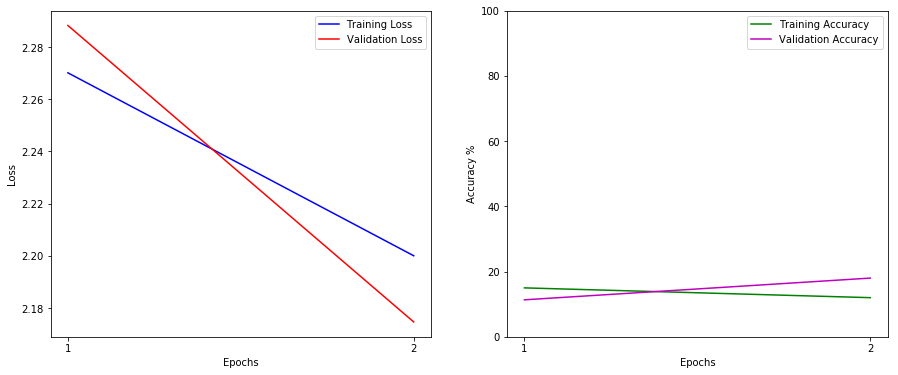


Epoch 3 of 5
Training	 Progress:	 0.000000 %	Loss: 2.153256	 Training Accuracy 28.00 %
Training	 Progress:	 1.597444 %	Loss: 2.117033	 Training Accuracy 12.00 %
Training	 Progress:	 3.194888 %	Loss: 2.342840	 Training Accuracy 18.00 %
Training	 Progress:	 4.792332 %	Loss: 2.265674	 Training Accuracy 9.00 %
Training	 Progress:	 6.389776 %	Loss: 2.162648	 Training Accuracy 15.00 %
Training	 Progress:	 7.987220 %	Loss: 2.151070	 Training Accuracy 6.00 %
Training	 Progress:	 9.584665 %	Loss: 2.188824	 Training Accuracy 21.00 %
Training	 Progress:	 11.182109 %	Loss: 2.157442	 Training Accuracy 18.00 %
Training	 Progress:	 12.779553 %	Loss: 2.058267	 Training Accuracy 21.00 %
Training	 Progress:	 14.376997 %	Loss: 2.264083	 Training Accuracy 9.00 %
Training	 Progress:	 15.974441 %	Loss: 2.275438	 Training Accuracy 9.00 %
Training	 Progress:	 17.571885 %	Loss: 2.229743	 Training Accuracy 12.00 %
Training	 Progress:	 19.169329 %	Loss: 2.146753	 Training Accuracy 25.00 %
Training	 Progress:	 2

<Figure size 432x288 with 0 Axes>

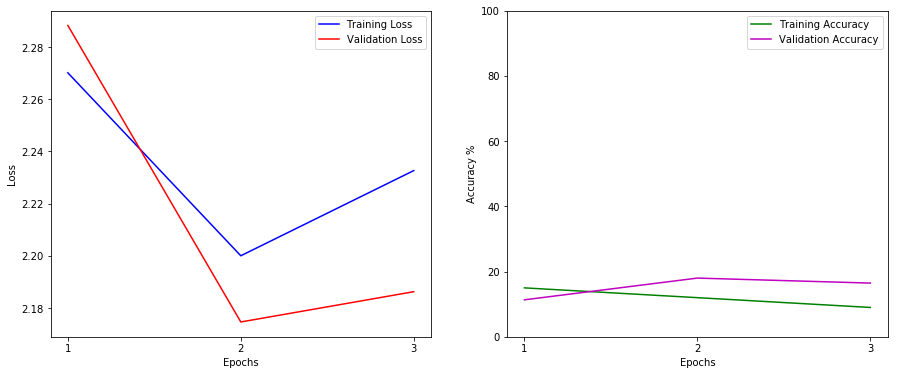


Epoch 4 of 5
Training	 Progress:	 0.000000 %	Loss: 2.171061	 Training Accuracy 18.00 %
Training	 Progress:	 1.597444 %	Loss: 2.249416	 Training Accuracy 15.00 %
Training	 Progress:	 3.194888 %	Loss: 2.199919	 Training Accuracy 12.00 %
Training	 Progress:	 4.792332 %	Loss: 2.242830	 Training Accuracy 9.00 %
Training	 Progress:	 6.389776 %	Loss: 2.179811	 Training Accuracy 31.00 %
Training	 Progress:	 7.987220 %	Loss: 2.303817	 Training Accuracy 12.00 %
Training	 Progress:	 9.584665 %	Loss: 2.249794	 Training Accuracy 12.00 %
Training	 Progress:	 11.182109 %	Loss: 2.151607	 Training Accuracy 21.00 %
Training	 Progress:	 12.779553 %	Loss: 2.192883	 Training Accuracy 31.00 %
Training	 Progress:	 14.376997 %	Loss: 2.162290	 Training Accuracy 15.00 %
Training	 Progress:	 15.974441 %	Loss: 2.262242	 Training Accuracy 12.00 %
Training	 Progress:	 17.571885 %	Loss: 2.169317	 Training Accuracy 15.00 %
Training	 Progress:	 19.169329 %	Loss: 2.124228	 Training Accuracy 25.00 %
Training	 Progress:

<Figure size 432x288 with 0 Axes>

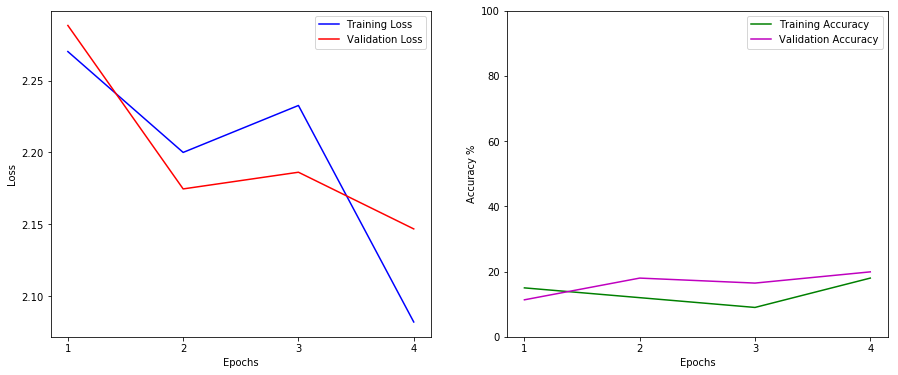


Epoch 5 of 5
Training	 Progress:	 0.000000 %	Loss: 2.080329	 Training Accuracy 18.00 %
Training	 Progress:	 1.597444 %	Loss: 2.185420	 Training Accuracy 21.00 %
Training	 Progress:	 3.194888 %	Loss: 2.195455	 Training Accuracy 12.00 %
Training	 Progress:	 4.792332 %	Loss: 2.048732	 Training Accuracy 25.00 %
Training	 Progress:	 6.389776 %	Loss: 2.033451	 Training Accuracy 28.00 %
Training	 Progress:	 7.987220 %	Loss: 2.255945	 Training Accuracy 18.00 %
Training	 Progress:	 9.584665 %	Loss: 2.029471	 Training Accuracy 12.00 %
Training	 Progress:	 11.182109 %	Loss: 2.164513	 Training Accuracy 15.00 %
Training	 Progress:	 12.779553 %	Loss: 2.194334	 Training Accuracy 25.00 %
Training	 Progress:	 14.376997 %	Loss: 2.222351	 Training Accuracy 6.00 %
Training	 Progress:	 15.974441 %	Loss: 2.154047	 Training Accuracy 18.00 %
Training	 Progress:	 17.571885 %	Loss: 2.166906	 Training Accuracy 15.00 %
Training	 Progress:	 19.169329 %	Loss: 2.126784	 Training Accuracy 31.00 %
Training	 Progress:

<Figure size 432x288 with 0 Axes>

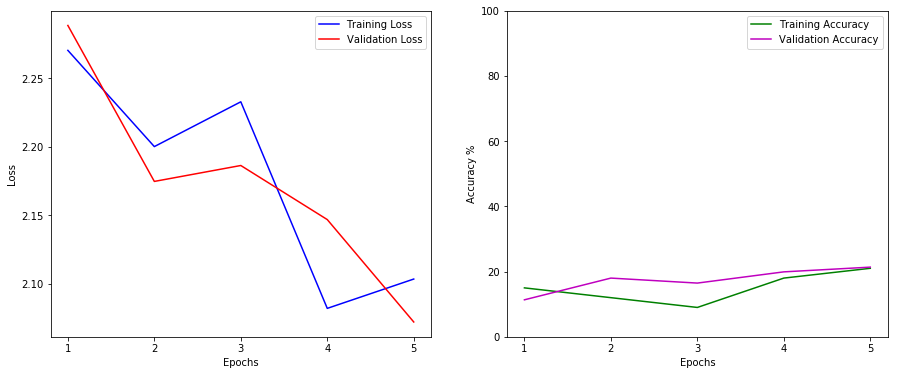

Round 0
testing accuracy 0.2136
Round 1

Epoch 1 of 5
Training	 Progress:	 0.000000 %	Loss: 2.152185	 Training Accuracy 15.00 %
Training	 Progress:	 1.453488 %	Loss: 2.042599	 Training Accuracy 18.00 %
Training	 Progress:	 2.906977 %	Loss: 2.026216	 Training Accuracy 28.00 %
Training	 Progress:	 4.360465 %	Loss: 2.313892	 Training Accuracy 18.00 %
Training	 Progress:	 5.813953 %	Loss: 1.937505	 Training Accuracy 28.00 %
Training	 Progress:	 7.267442 %	Loss: 2.359254	 Training Accuracy 12.00 %
Training	 Progress:	 8.720930 %	Loss: 2.007765	 Training Accuracy 43.00 %
Training	 Progress:	 10.174419 %	Loss: 2.154725	 Training Accuracy 18.00 %
Training	 Progress:	 11.627907 %	Loss: 2.180483	 Training Accuracy 25.00 %
Training	 Progress:	 13.081395 %	Loss: 2.230172	 Training Accuracy 34.00 %
Training	 Progress:	 14.534884 %	Loss: 1.889001	 Training Accuracy 21.00 %
Training	 Progress:	 15.988372 %	Loss: 2.110567	 Training Accuracy 18.00 %
Training	 Progress:	 17.441860 %	Loss: 2.402060	 Trai

<Figure size 432x288 with 0 Axes>

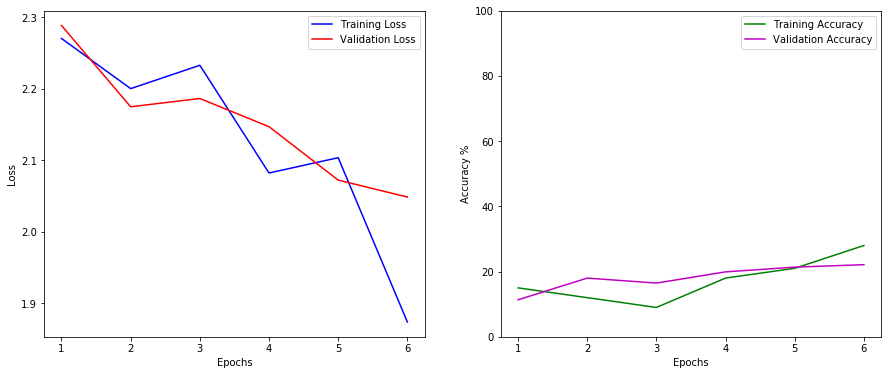


Epoch 2 of 5
Training	 Progress:	 0.000000 %	Loss: 2.295982	 Training Accuracy 15.00 %
Training	 Progress:	 1.453488 %	Loss: 1.934369	 Training Accuracy 28.00 %
Training	 Progress:	 2.906977 %	Loss: 1.929251	 Training Accuracy 34.00 %
Training	 Progress:	 4.360465 %	Loss: 1.915318	 Training Accuracy 18.00 %
Training	 Progress:	 5.813953 %	Loss: 1.962450	 Training Accuracy 28.00 %
Training	 Progress:	 7.267442 %	Loss: 1.842477	 Training Accuracy 34.00 %
Training	 Progress:	 8.720930 %	Loss: 2.125149	 Training Accuracy 21.00 %
Training	 Progress:	 10.174419 %	Loss: 1.998176	 Training Accuracy 31.00 %
Training	 Progress:	 11.627907 %	Loss: 2.162084	 Training Accuracy 25.00 %
Training	 Progress:	 13.081395 %	Loss: 1.989994	 Training Accuracy 31.00 %
Training	 Progress:	 14.534884 %	Loss: 1.911018	 Training Accuracy 31.00 %
Training	 Progress:	 15.988372 %	Loss: 1.950085	 Training Accuracy 31.00 %
Training	 Progress:	 17.441860 %	Loss: 2.085520	 Training Accuracy 25.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

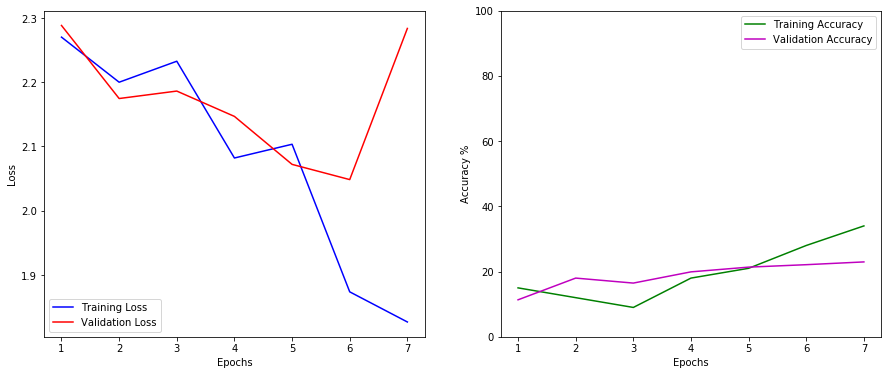


Epoch 3 of 5
Training	 Progress:	 0.000000 %	Loss: 2.206387	 Training Accuracy 15.00 %
Training	 Progress:	 1.453488 %	Loss: 1.816450	 Training Accuracy 28.00 %
Training	 Progress:	 2.906977 %	Loss: 1.873271	 Training Accuracy 37.00 %
Training	 Progress:	 4.360465 %	Loss: 1.982177	 Training Accuracy 28.00 %
Training	 Progress:	 5.813953 %	Loss: 1.934375	 Training Accuracy 31.00 %
Training	 Progress:	 7.267442 %	Loss: 2.150669	 Training Accuracy 12.00 %
Training	 Progress:	 8.720930 %	Loss: 2.086758	 Training Accuracy 21.00 %
Training	 Progress:	 10.174419 %	Loss: 1.805490	 Training Accuracy 28.00 %
Training	 Progress:	 11.627907 %	Loss: 2.074272	 Training Accuracy 15.00 %
Training	 Progress:	 13.081395 %	Loss: 1.934223	 Training Accuracy 34.00 %
Training	 Progress:	 14.534884 %	Loss: 2.129586	 Training Accuracy 12.00 %
Training	 Progress:	 15.988372 %	Loss: 2.266943	 Training Accuracy 18.00 %
Training	 Progress:	 17.441860 %	Loss: 1.955412	 Training Accuracy 31.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

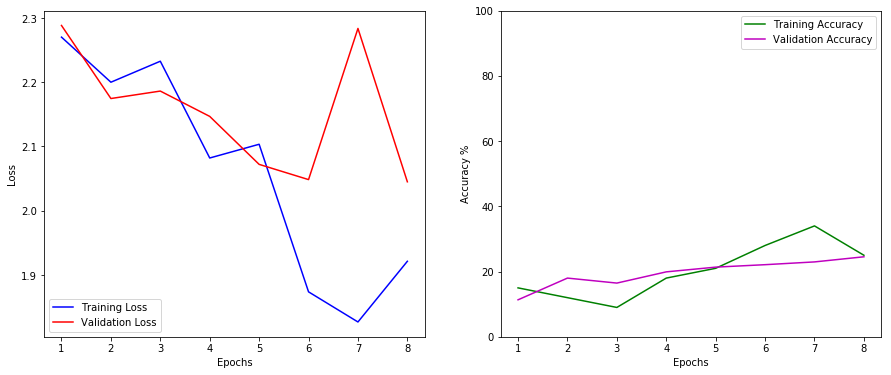


Epoch 4 of 5
Training	 Progress:	 0.000000 %	Loss: 1.987131	 Training Accuracy 31.00 %
Training	 Progress:	 1.453488 %	Loss: 1.630823	 Training Accuracy 34.00 %
Training	 Progress:	 2.906977 %	Loss: 1.874470	 Training Accuracy 34.00 %
Training	 Progress:	 4.360465 %	Loss: 2.119417	 Training Accuracy 25.00 %
Training	 Progress:	 5.813953 %	Loss: 1.882372	 Training Accuracy 28.00 %
Training	 Progress:	 7.267442 %	Loss: 1.954542	 Training Accuracy 37.00 %
Training	 Progress:	 8.720930 %	Loss: 1.881411	 Training Accuracy 28.00 %
Training	 Progress:	 10.174419 %	Loss: 1.894887	 Training Accuracy 25.00 %
Training	 Progress:	 11.627907 %	Loss: 2.038766	 Training Accuracy 25.00 %
Training	 Progress:	 13.081395 %	Loss: 2.219803	 Training Accuracy 25.00 %
Training	 Progress:	 14.534884 %	Loss: 2.130706	 Training Accuracy 21.00 %
Training	 Progress:	 15.988372 %	Loss: 2.261735	 Training Accuracy 12.00 %
Training	 Progress:	 17.441860 %	Loss: 2.024515	 Training Accuracy 25.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

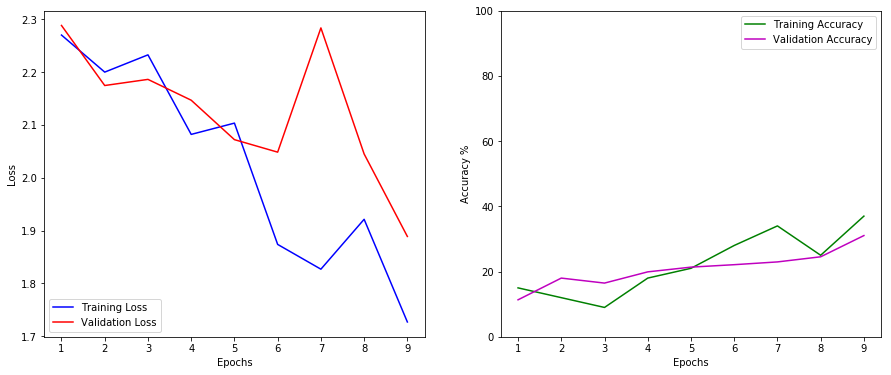


Epoch 5 of 5
Training	 Progress:	 0.000000 %	Loss: 1.922445	 Training Accuracy 34.00 %
Training	 Progress:	 1.453488 %	Loss: 2.113301	 Training Accuracy 25.00 %
Training	 Progress:	 2.906977 %	Loss: 1.693654	 Training Accuracy 40.00 %
Training	 Progress:	 4.360465 %	Loss: 1.587527	 Training Accuracy 53.00 %
Training	 Progress:	 5.813953 %	Loss: 2.135381	 Training Accuracy 25.00 %
Training	 Progress:	 7.267442 %	Loss: 1.960819	 Training Accuracy 28.00 %
Training	 Progress:	 8.720930 %	Loss: 1.908703	 Training Accuracy 28.00 %
Training	 Progress:	 10.174419 %	Loss: 1.832256	 Training Accuracy 37.00 %
Training	 Progress:	 11.627907 %	Loss: 1.709156	 Training Accuracy 21.00 %
Training	 Progress:	 13.081395 %	Loss: 1.688933	 Training Accuracy 46.00 %
Training	 Progress:	 14.534884 %	Loss: 2.347611	 Training Accuracy 31.00 %
Training	 Progress:	 15.988372 %	Loss: 1.837618	 Training Accuracy 43.00 %
Training	 Progress:	 17.441860 %	Loss: 1.902509	 Training Accuracy 43.00 %
Training	 Progress

<Figure size 432x288 with 0 Axes>

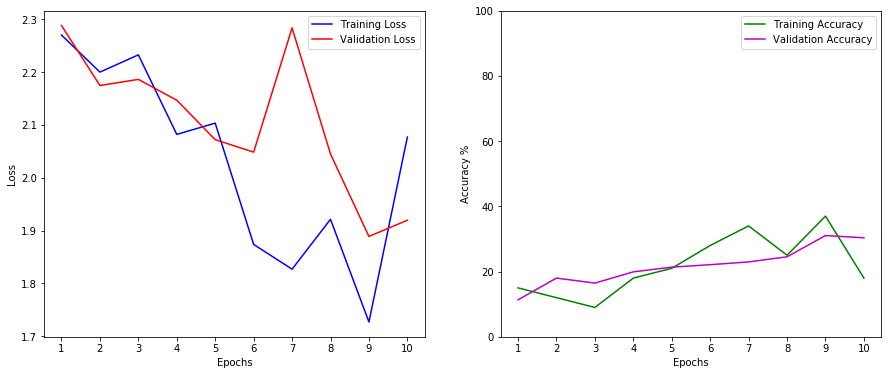

testing accuracy 0.3036
Graphs have been saved to: 2019-09-30T14:35:33 files


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

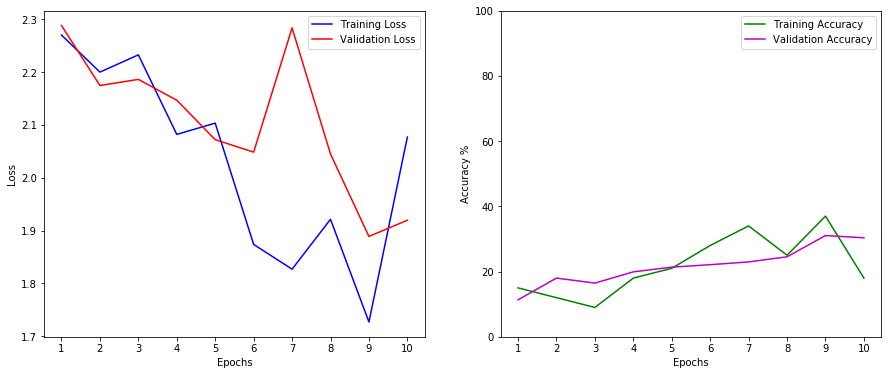

[tensor(2.2702, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.2000, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.2327, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.0821, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.1034, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8737, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8268, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.9213, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.7269, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.0770, device='cuda:0', grad_fn=<NllLossBackward>)]
[tensor(2.2883, device='cuda:0'), tensor(2.1746, device='cuda:0'), tensor(2.1862, device='cuda:0'), tensor(2.1468, device='cuda:0'), tensor(2.0721, device='cuda:0'), tensor(2.0484, device='cuda:0'), tensor(2.2837, device='cuda:0'), tensor(2.0450, device='cuda:0'), tensor(1.8888, device='cuda:0'), tensor(1.9196, device='cuda:0')]
[15, 12, 9, 18, 21, 28, 34, 25, 37, 18]
[11.34, 18.0, 16.47, 19.91, 

In [5]:
import numpy as np
import copy
#from dataset import get_dataset, get_handler
#from model import get_net
from torchvision import transforms
import torch
#from query_strategies import RandomSampling, LeastConfidence, MarginSampling, EntropySampling, \
#                                LeastConfidenceDropout, MarginSamplingDropout, EntropySamplingDropout, \
#                                KMeansSampling, KCenterGreedy, BALDDropout, CoreSet, \
#                                AdversarialBIM, AdversarialDeepFool, ActiveLearningByLearning




print("Running...")
# parameters
SEED = 1

NUM_INIT_LB = 10000
NUM_QUERY = 1000
NUM_ROUND = 1

results_dict = {}
#DATA_NAME = 'MNIST'
# DATA_NAME = 'FashionMNIST'
#DATA_NAME = 'SVHN'
for net_name, pretrained in [('Inception3', True),('Densenet',True),('Squeezenet', True),('Inception3', False),('Densenet',False),('Squeezenet', False)]:
    print('=========== Training Model : %s, Pretrained : %s ====================='%(net_name,str(pretrained)))
    results_dict[net_name+'_Pretrained' if pretrained else net_name+'_Untrained']={}
    input_size=299 if net_name == 'Inception3' else 224

    DATA_NAME = 'CIFAR10'

    args_pool = {'MNIST':
                    {'n_epoch': 5, 'transform': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
                     'loader_tr_args':{'batch_size': 64, 'num_workers': 1},
                     'loader_te_args':{'batch_size': 1000, 'num_workers': 1},
                     'optimizer_args':{'lr': 0.01, 'momentum': 0.5}},
                'FashionMNIST':
                    {'n_epoch': 10, 'transform': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
                     'loader_tr_args':{'batch_size': 64, 'num_workers': 1},
                     'loader_te_args':{'batch_size': 1000, 'num_workers': 1},
                     'optimizer_args':{'lr': 0.01, 'momentum': 0.5}},
                'SVHN':
                    {'n_epoch': 20, 'transform': transforms.Compose([transforms.Resize(input_size), transforms.ToTensor(), 
                                                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                     'loader_tr_args':{'batch_size': 64, 'num_workers': 1},
                     'loader_te_args':{'batch_size': 1000, 'num_workers': 1},
                     'optimizer_args':{'lr': 0.01, 'momentum': 0.5}},
                'CIFAR10':
                    {'n_epoch': 5, 'transform': transforms.Compose([transforms.Resize(input_size), transforms.ToTensor(), 
                                                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                     'loader_tr_args':{'batch_size': 32, 'num_workers': 1},
                     'loader_te_args':{'batch_size': 128, 'num_workers': 1},
                     'optimizer_args':{'lr': 0.05, 'momentum': 0.3}} ## Need to check this once.
                }
    args = args_pool[DATA_NAME]

    # set seed
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.enabled = False

    # load dataset
    X_tr, Y_tr, X_te, Y_te = get_dataset(DATA_NAME)
    X_tr = X_tr[:40000]
    Y_tr = Y_tr[:40000]

    # start experiment
    n_pool = len(Y_tr)
    n_test = len(Y_te)
    print('number of labeled pool: {}'.format(NUM_INIT_LB))
    print('number of unlabeled pool: {}'.format(n_pool - NUM_INIT_LB))
    print('number of testing pool: {}'.format(n_test))

    # generate initial labeled pool
    idxs_lb = np.zeros(n_pool, dtype=bool)
    idxs_tmp = np.arange(n_pool)
    np.random.shuffle(idxs_tmp)
    idxs_lb[idxs_tmp[:NUM_INIT_LB]] = True

    # load network
    net = get_net(DATA_NAME, net_name, pretrained)
    print(type(net))
    handler = get_handler(DATA_NAME)

    strategy = RandomSampling(X_tr, Y_tr, idxs_lb, net, handler, args)

    # print info
    print(DATA_NAME)
    print('SEED {}'.format(SEED))
    print(type(strategy).__name__)

    # round 0 accuracy
    strategy.set_test_data(x=X_te, y=Y_te)
    strategy.train()
    P = strategy.predict(X_te, Y_te)
    acc = np.zeros(NUM_ROUND+1)
    acc[0] = 1.0 * (Y_te==P).sum().item() / len(Y_te)
    print('Round 0\ntesting accuracy {}'.format(acc[0]))


    for rd in range(1, NUM_ROUND+1):
        print('='*100+'\n' + '='*100) 
        print('Round {}'.format(rd))

        # query
        q_idxs = strategy.query(NUM_QUERY)
        idxs_lb[q_idxs] = True

        # update
        strategy.update(idxs_lb)
        strategy.train()

        # round accuracy
        P = strategy.predict(X_te, Y_te)
        acc[rd] = 1.0 * (Y_te==P).sum().item() / len(Y_te)
        print('testing accuracy {}'.format(acc[rd]))

    strategy.save_graph()
    strategy.plot_graphs(pause=True)
    print(strategy.train_losses)
    print(strategy.val_losses)
    print(strategy.train_acc)
    print(strategy.val_acc)
    results_dict[net_name+'_Pretrained' if pretrained else net_name+'_Untrained']['Train_Loss'] = strategy.train_losses
    results_dict[net_name+'_Pretrained' if pretrained else net_name+'_Untrained']['Validation_Loss'] = strategy.val_losses
    results_dict[net_name+'_Pretrained' if pretrained else net_name+'_Untrained']['Train_Accuracy'] = strategy.train_acc
    results_dict[net_name+'_Pretrained' if pretrained else net_name+'_Untrained']['Validation_Accuracy'] = strategy.val_acc

    # print results
    print('SEED {}'.format(SEED))
    print(type(strategy).__name__)
    print(acc)

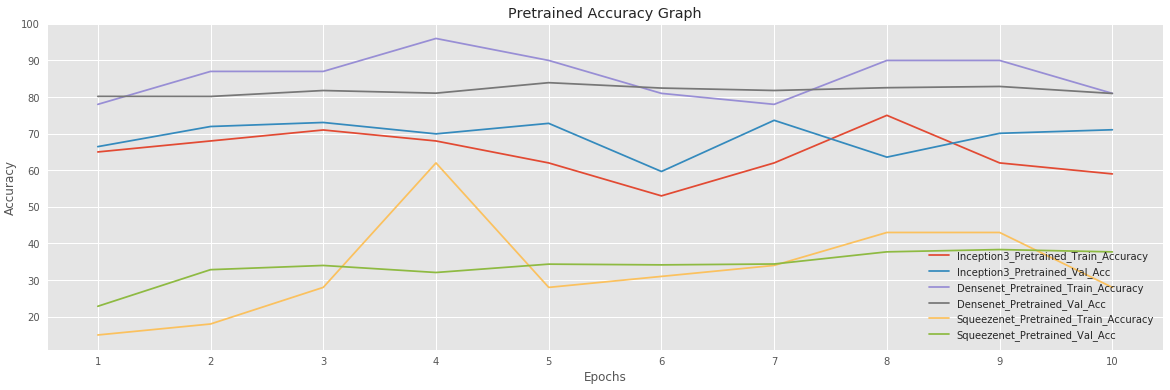

In [6]:
with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(20,6))
    for key in results_dict.keys():
        if 'Pretrained' in key:
            train_acc = results_dict[key]['Train_Accuracy']
            val_acc = results_dict[key]['Validation_Accuracy']
            plt.plot(train_acc, label=key+'_Train_Accuracy')
            plt.plot(val_acc, label=key+'_Val_Acc')
            plt.xticks(range(len(train_acc)), range(1, len(train_acc)+1))
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.title('Pretrained Accuracy Graph')
            plt.legend(loc='best')
    plt.savefig('pretrained_acc.png')

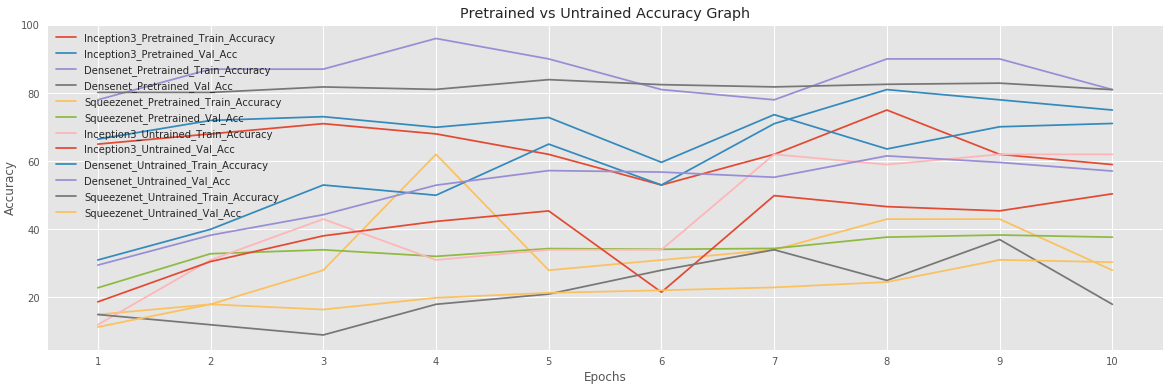

In [7]:
with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(20,6))
    for key in results_dict.keys():
        train_acc = results_dict[key]['Train_Accuracy']
        val_acc = results_dict[key]['Validation_Accuracy']
        plt.plot(train_acc, label=key+'_Train_Accuracy')
        plt.plot(val_acc, label=key+'_Val_Acc')
        plt.xticks(range(len(train_acc)), range(1, len(train_acc)+1))
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Pretrained vs Untrained Accuracy Graph')
        plt.legend(loc='best')
    plt.savefig('pretrained_untrained_acc.png')

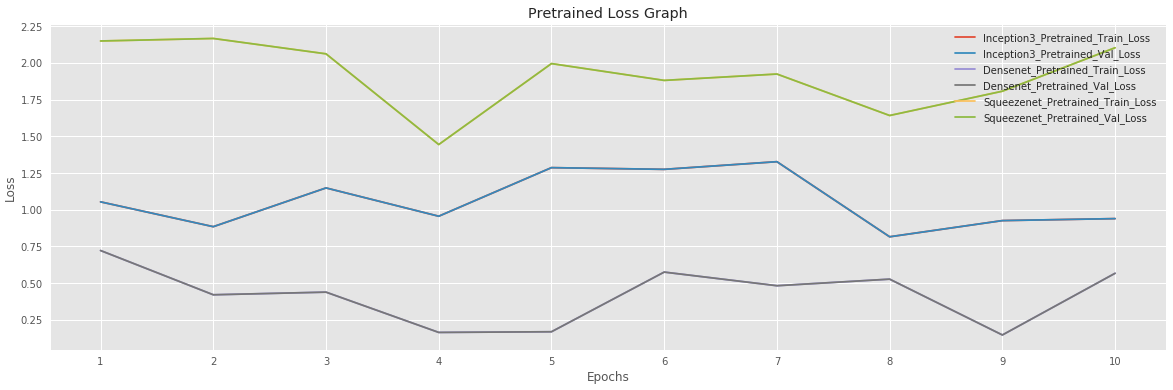

In [8]:
with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(20,6))
    for key in results_dict.keys():
        if 'Pretrained' in key:
            train_losses = results_dict[key]['Train_Loss']
            val_losses = results_dict[key]['Validation_Loss']
            plt.plot(train_losses, label=key+'_Train_Loss')
            plt.plot(train_losses, label=key+'_Val_Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.xticks(range(len(train_losses)), range(1, len(train_losses)+1))
            plt.title('Pretrained Loss Graph')
            plt.legend(loc='best')
    plt.savefig('pretrained_loss.png')

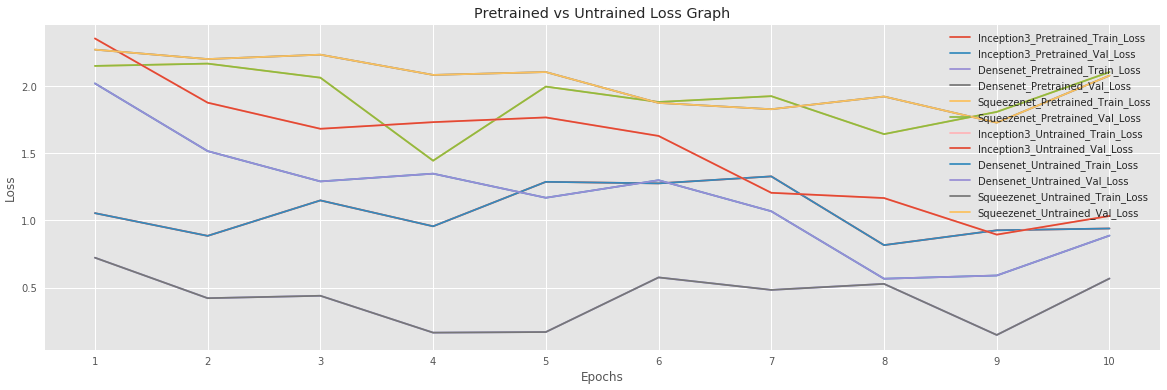

In [9]:
with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(20,6))
    for key in results_dict.keys():
        train_losses = results_dict[key]['Train_Loss']
        val_losses = results_dict[key]['Validation_Loss']
        plt.plot(train_losses, label=key+'_Train_Loss')
        plt.plot(train_losses, label=key+'_Val_Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.xticks(range(len(train_losses)), range(1, len(train_losses)+1))
        plt.title('Pretrained vs Untrained Loss Graph')
        plt.legend(loc='best')
    plt.savefig('pretrained_untrained_loss.png')